# Analyzing NYTbd Sample 4
<br>
This notebook is looking at the NYTbd Sample 4 content analyzed by ACCENT and PETRARCH2 to identify current limitations with PETRARCH2 and to try and devise solutions. 

In [2]:
# Setup Environment
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.parse import CoreNLPParser

import pandas as pd

import pprint
import nltk

from nltk.tree import *
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Link to Java Server for Standford CoreNLP
<br>
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse,sentiment" -port 9000 -timeout 100000

In [4]:
# Connect to Server
parser = CoreNLPParser('http://localhost:9000')
depr = CoreNLPDependencyParser('http://localhost:9000')

#### Write Some Functions for Parsing Text

In [5]:
# Core Parser- save as df['parsed']
def core_parser(df, col):
    parse = []
    i = ""
    for i in range(len(df)):
        parse.append(i)
        parse[i] = next(parser.raw_parse(df[col].iloc[i]))
    return parse

# Dependency Parser- save as df['dep']
def dep_parser(df, col):
    dep = []
    i = ""
    for i in range(len(df)):
        dep.append(i)
        dep[i] = next(depr.raw_parse(df[col].iloc[i]))
    return dep

# For easy display of both parse trees, text, and code
def easy_read(corp, index_num):
    display(corp['parsed'].iloc[index_num])
    display(corp['dep'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    
# function to display only constituency parse with POS tags with text and code
def parsed_output(corp, index_num):
    display("AID = " + str(corp.iloc[index_num].loc['aid']))
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    display("Text = " + corp.iloc[index_num].loc['text'])
    display(corp['parsed'].iloc[index_num])

# function to display only dependency parse with text and code
def dependency_output(corp, index_num):
    display(corp['dep'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    
# function to display constituency parse of a single sentence
def one_sentence_parser(text):
    output = next(parser.raw_parse(text))
    return output

## Read in NYTbd Sample 3 Data- ACCENT and PETRARCH

In [6]:
accent4 = pd.read_stata("/Volumes/PartTime/Jonathan Bonaguro - Spring 2020/NYTbd sample 4/Accent_sample4_events_text.dta")
petrarch4_full = pd.read_stata("/Volumes/PartTime/Jonathan Bonaguro - Spring 2020/NYTbd sample 4/Petrarch_NYTbd_sample4_run1_events_text.dta")

In [7]:
# Identify codes of events that ACCENT identified
relevant_codes = accent4.code.unique()

# Trim the PETRARCH output to only event codes that ACCENT identified
petrarch4 = petrarch4_full[petrarch4_full['code'].isin(relevant_codes)]

# Convert Data Types to int64
petrarch4['code'] = petrarch4['code'].astype('int32')
petrarch4['aid'] = petrarch4['aid'].astype('int32')

accent4['code'] = accent4['code'].astype('int32')
accent4['aid'] = accent4['aid'].astype('int32')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
# Parse both PETRARCH and ACCENT with Stanford CoreNLP
%time 
accent4['parsed'] = core_parser(accent4, 'text')
accent4['dep'] = dep_parser(accent4, 'text')

petrarch4['parsed'] = core_parser(petrarch4, 'text')
petrarch4['dep'] = dep_parser(petrarch4, 'text')

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
keys = list(['aid', 'code'])
accent4_index = accent4.set_index(keys).index
petrarch4_index = petrarch4.set_index(keys).index

# Produce df's of mutually exclusive events 
accent4_only = accent4[~accent4_index.isin(petrarch4_index)]
petrarch4_only = petrarch4[~petrarch4_index.isin(accent4_index)]

# Produce df's of same article, same coding
accent4_same_code = accent4[accent4_index.isin(petrarch4_index)]
petrarch4_same_code = petrarch4[petrarch4_index.isin(accent4_index)]

# sort values on AID and reset index 
accent4_only = accent4_only.sort_values('aid').reset_index(drop = True)
petrarch4_only = petrarch4_only.sort_values('aid').reset_index(drop = True)

accent4_same_code = accent4_same_code.sort_values('aid').reset_index(drop = True)
petrarch4_same_code = petrarch4_same_code.sort_values('aid').reset_index(drop = True)

## Look for errors in ACCENT and remove from data
<br>
Event codes: 140, 141, 143, 145, 1723, 181, 183, 1831, 186

In [10]:
# basic loop to print tree, text, aid, and number in loop

# for i in range(len(accent4_only[accent4_only.code == 145])):
#    parsed_output(accent4_only[accent4_only.code == 145], i)
#    display(i)

In [40]:
## Create subsets of data discarding identified errors in ACCENT coding
#### Refer to 'ACCENT_RUN4_ERRORS.docx' for list of errors and explanation
# event code 141
accent4_141 = accent4_only[accent4_only.code == 141].reset_index(drop = True).drop([19]).reset_index(drop = True)

# event code 143
accent4_143 = accent4_only[accent4_only.code == 143].reset_index(drop = True).drop([5, 13, 21]).reset_index(drop = True)

# event code 145
accent4_145 = accent4_only[accent4_only.code == 145].reset_index(drop = True).drop([2, 7, 12]).reset_index(drop = True)

# event code 1723
accent4_1723 = accent4_only[accent4_only.code == 1723].reset_index(drop = True).reset_index(drop = True)

# event code 181
accent4_181 = accent4_only[accent4_only.code == 181].reset_index(drop = True).reset_index(drop = True)

# event code 1841
accent4_1831 = accent4_only[accent4_only.code == 1831].reset_index(drop = True).drop([1]).reset_index(drop = True)

# event code 186
accent4_186 = accent4_only[accent4_only.code == 186].reset_index(drop = True).drop([2]).reset_index(drop = True)

## Print ACCENT Output to Identify Dictionary Improvements

'AID = 22399802'

'Code = 186'

'Text = "Guerrillas shot and killed three election officials in Teheran, the Teheran radio said today.'

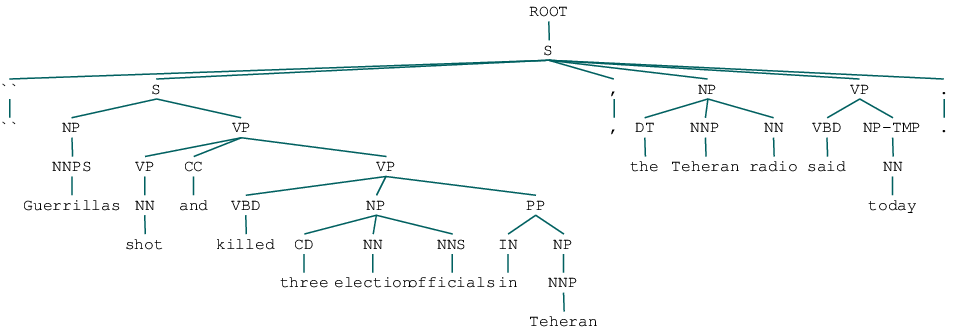

0

'AID = 22443787'

'Code = 186'

'Text = A platoon-sized group of noncommissioned officers burst into the executive mansion and assassinated President William Tolbert.'

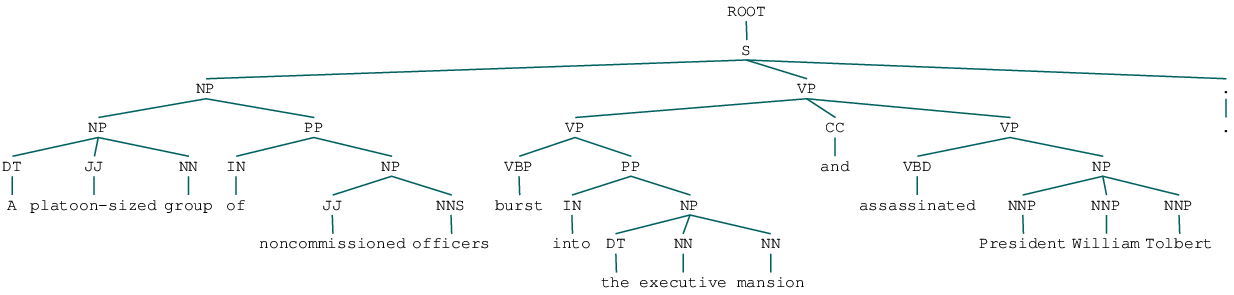

1

'AID = 22502080'

'Code = 186'

"Text = What is different about the recently published ''Crime of the Century'' by Michael Kurtz, which contends that conspirators killed the President in a carefully planned crossfire of four shots, is that the book has been published not by a commercial publisher, but by the University of Tennessee Press.\\n\\n\\n\\n''We knew it was a good book, but we did not know of all the continuing interest in the Kennedy assassination,'' said Carol Orr, director of the press."

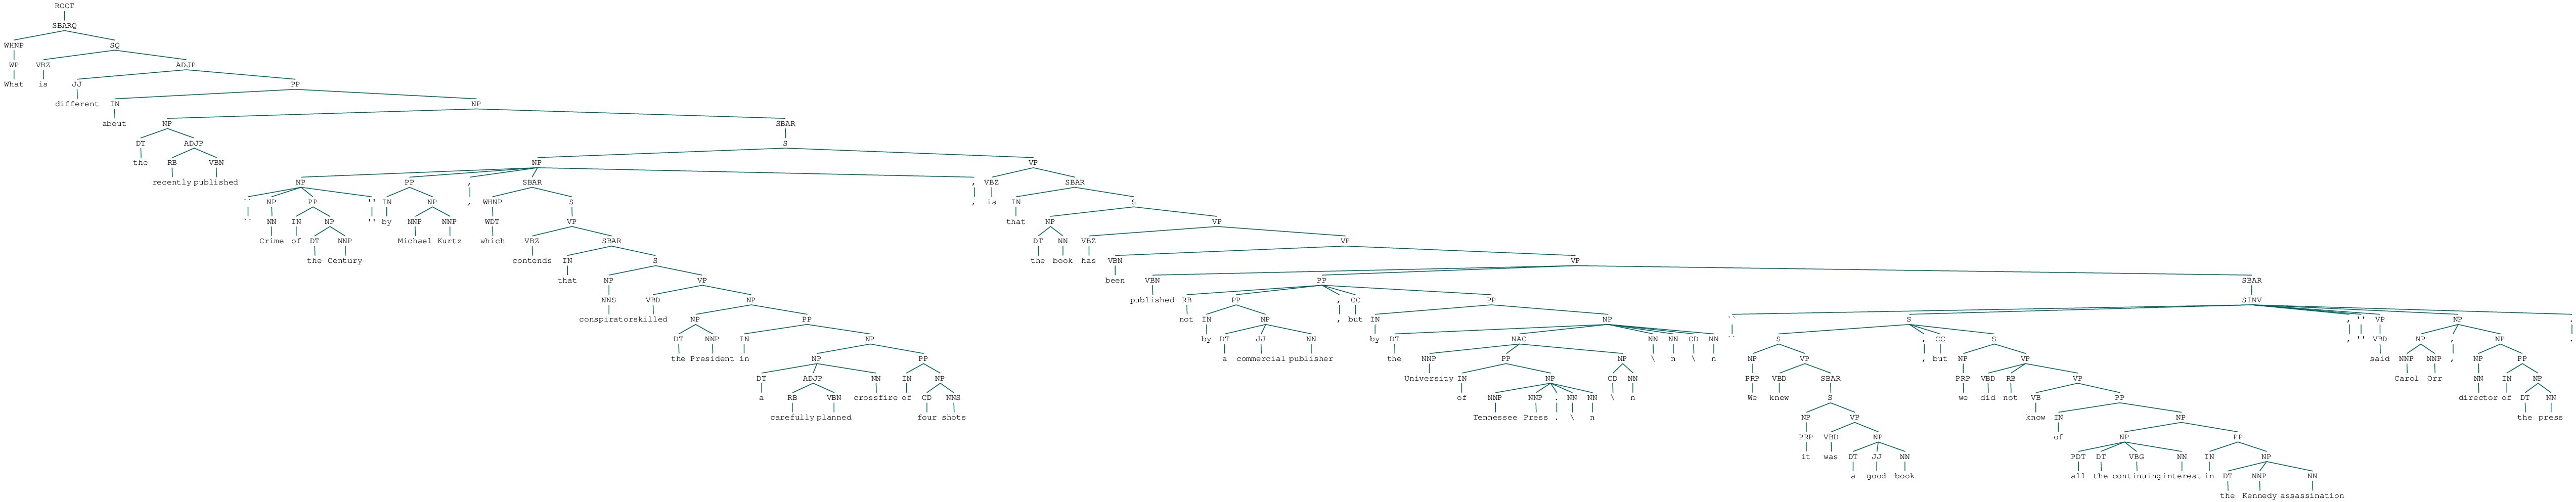

2

'AID = 22710837'

'Code = 186'

"Text = Many politicians predict that a party led by Sikhs would have a better chance than Mr. Gandhi's group of curbing terrorism by Sikh radicals.\\n\\n\\nLast year, Prime Minister Indira Gandhi angered even moderate Sikhs by directing the army to oust armed radicals from the Golden Temple at Amritsar, the holiest Sikh shrine.\\nIn apparent retaliation, Mrs. Gandhi was assassinated last October, purportedly by two Sikh guards."

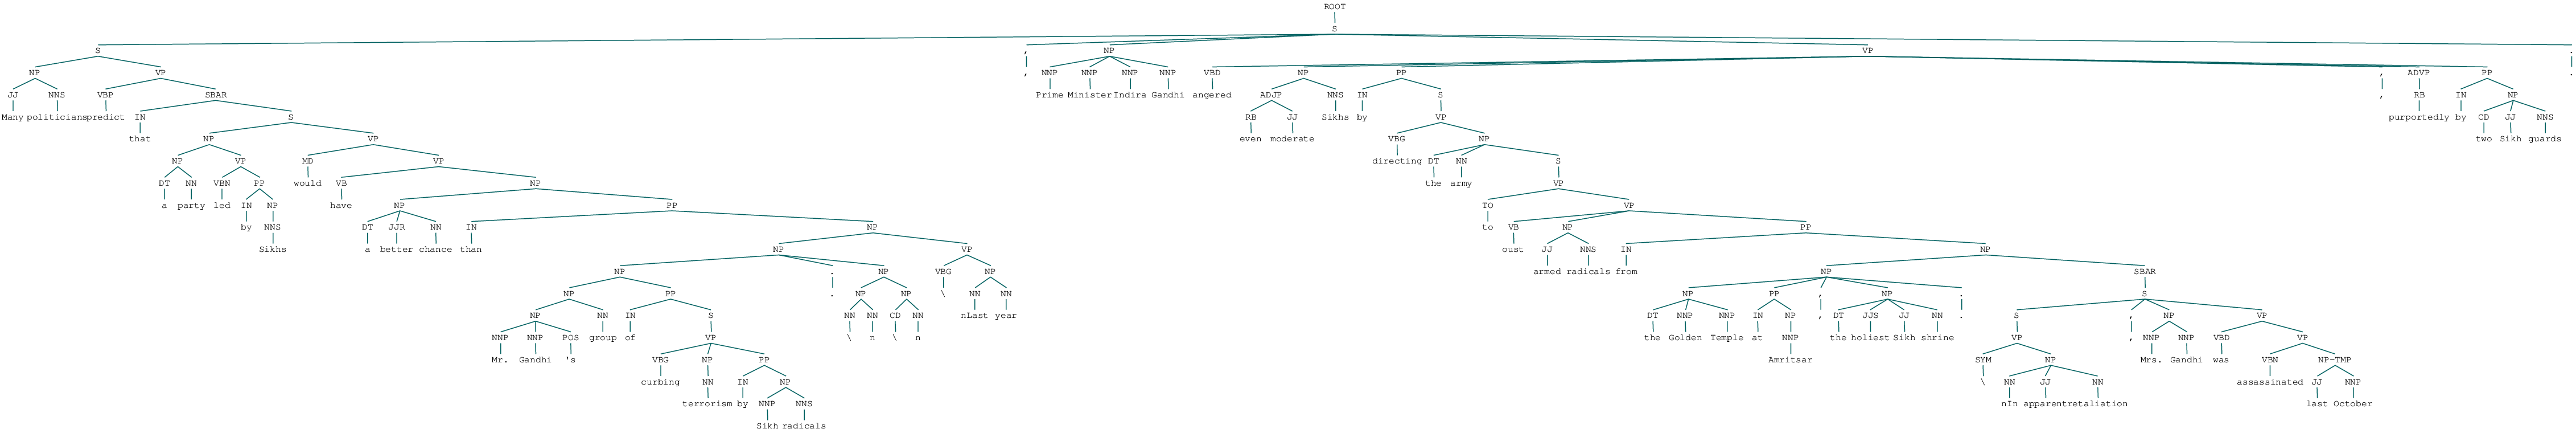

3

'AID = 22716853'

'Code = 186'

'Text = That inmate, Thomas Andy Barefoot, was executed Oct. 30, 1984, for killing a police officer.\\n\\n\\nSince then judges in Texas and other states have been trying to clear up the backlog and there has been little opposition from the political leadership.'

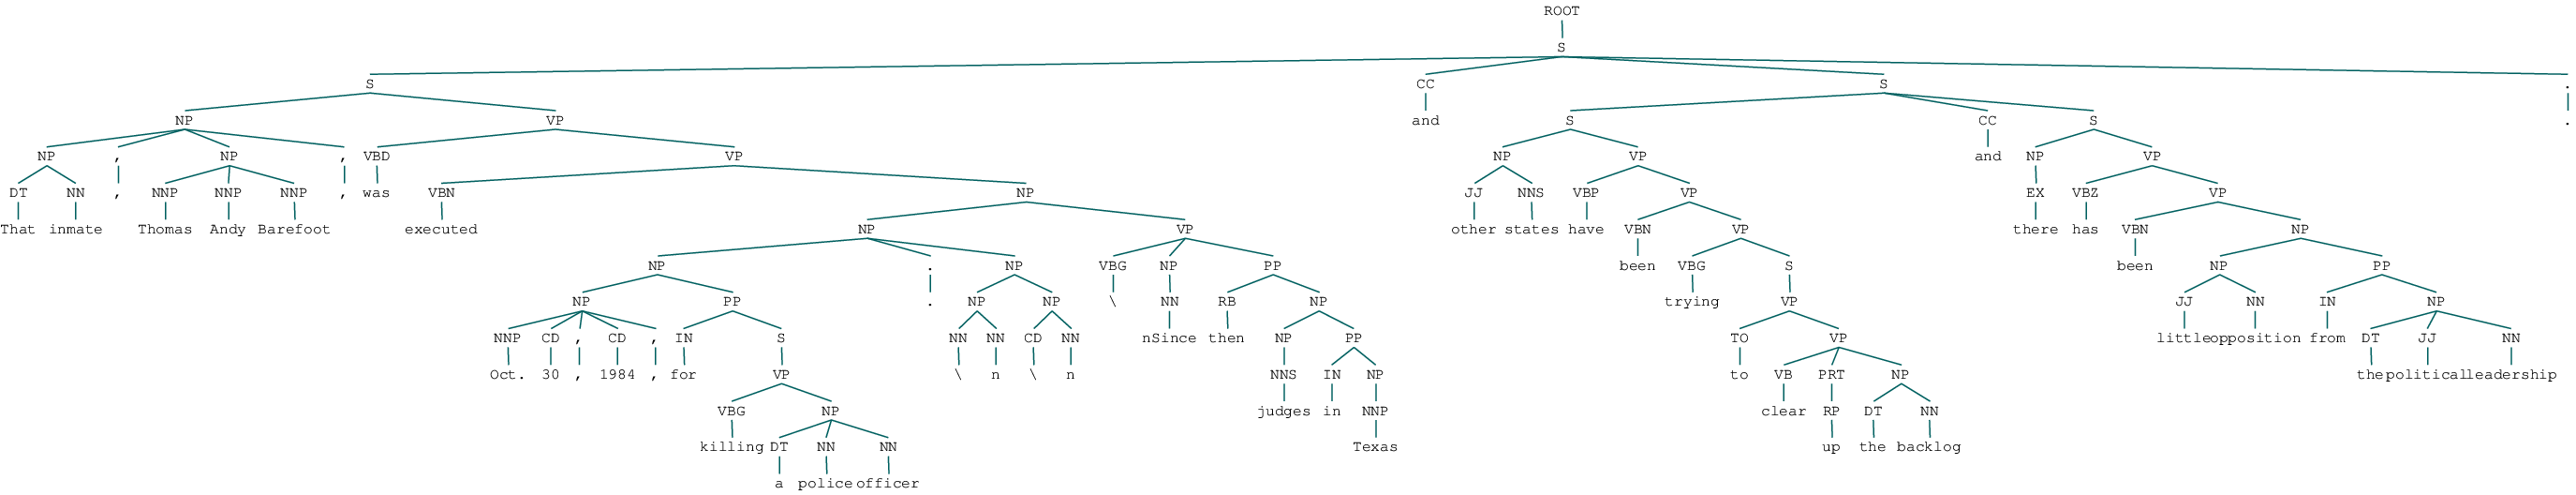

4

'AID = 22778018'

'Code = 186'

'Text = Some Reportedly Flee Homes \\nSeveral Christian families in East Beirut have fled their homes and taken refuge with Mr. Hobeika in Zahle, according to news reports published here.\\nToday, a leftist newspaper printed in a front-page story what it said were the names of the gunmen who assassinated a leading Christian army officer last month.\\nAs Safir, a daily that is published in West Beirut, said the slaying of the officer, Col. Khalil Kanaan, a Maronite, was planned by Nader Sukkar and carried out by Hani Rahmeh,'

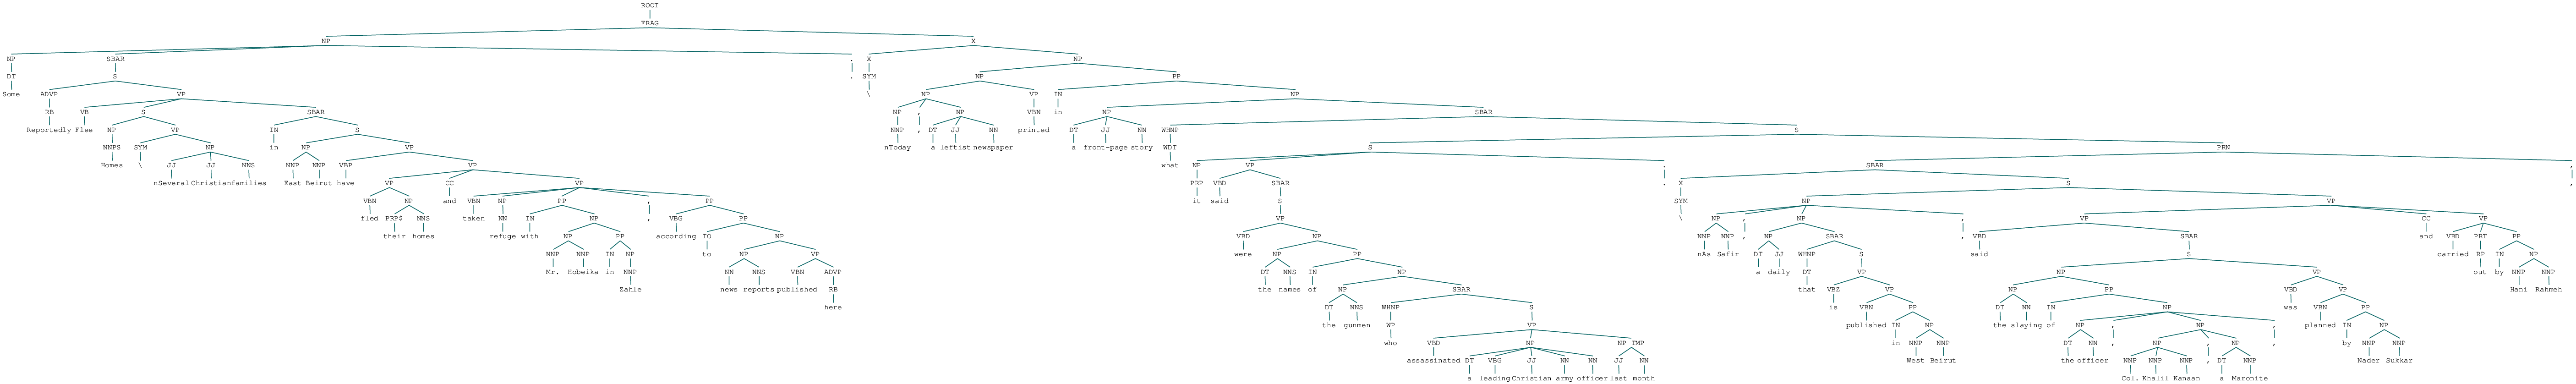

5

'AID = 22870763'

'Code = 186'

'Text = In 1959, her husband, Prime Minister S. W. R. D. Bandaranaike, was assassinated by a Sinhalese fanatic.'

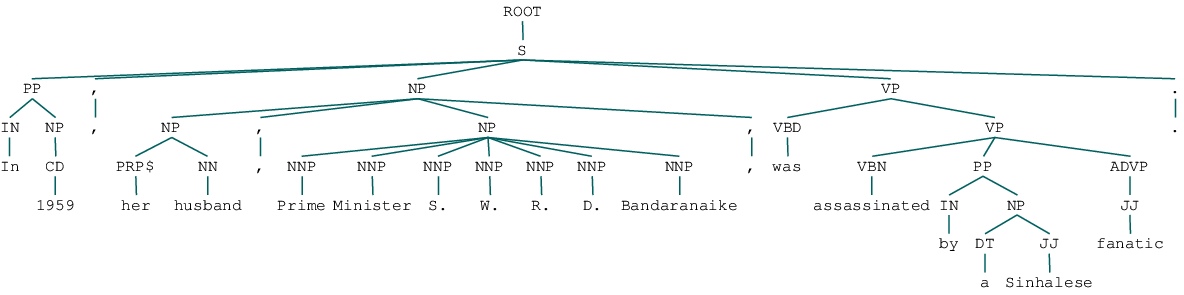

6

'AID = 22917332'

'Code = 186'

'Text = The case grew out of the 1982 trial of 300 Moslem fundamentalists belonging to an underground group called Holy War who were charged with trying to overthrow the Government in the wake of Mr. Sadat\'s assassination by Moslem extremists at a military parade in Cairo on Oct. 6, 1981."'

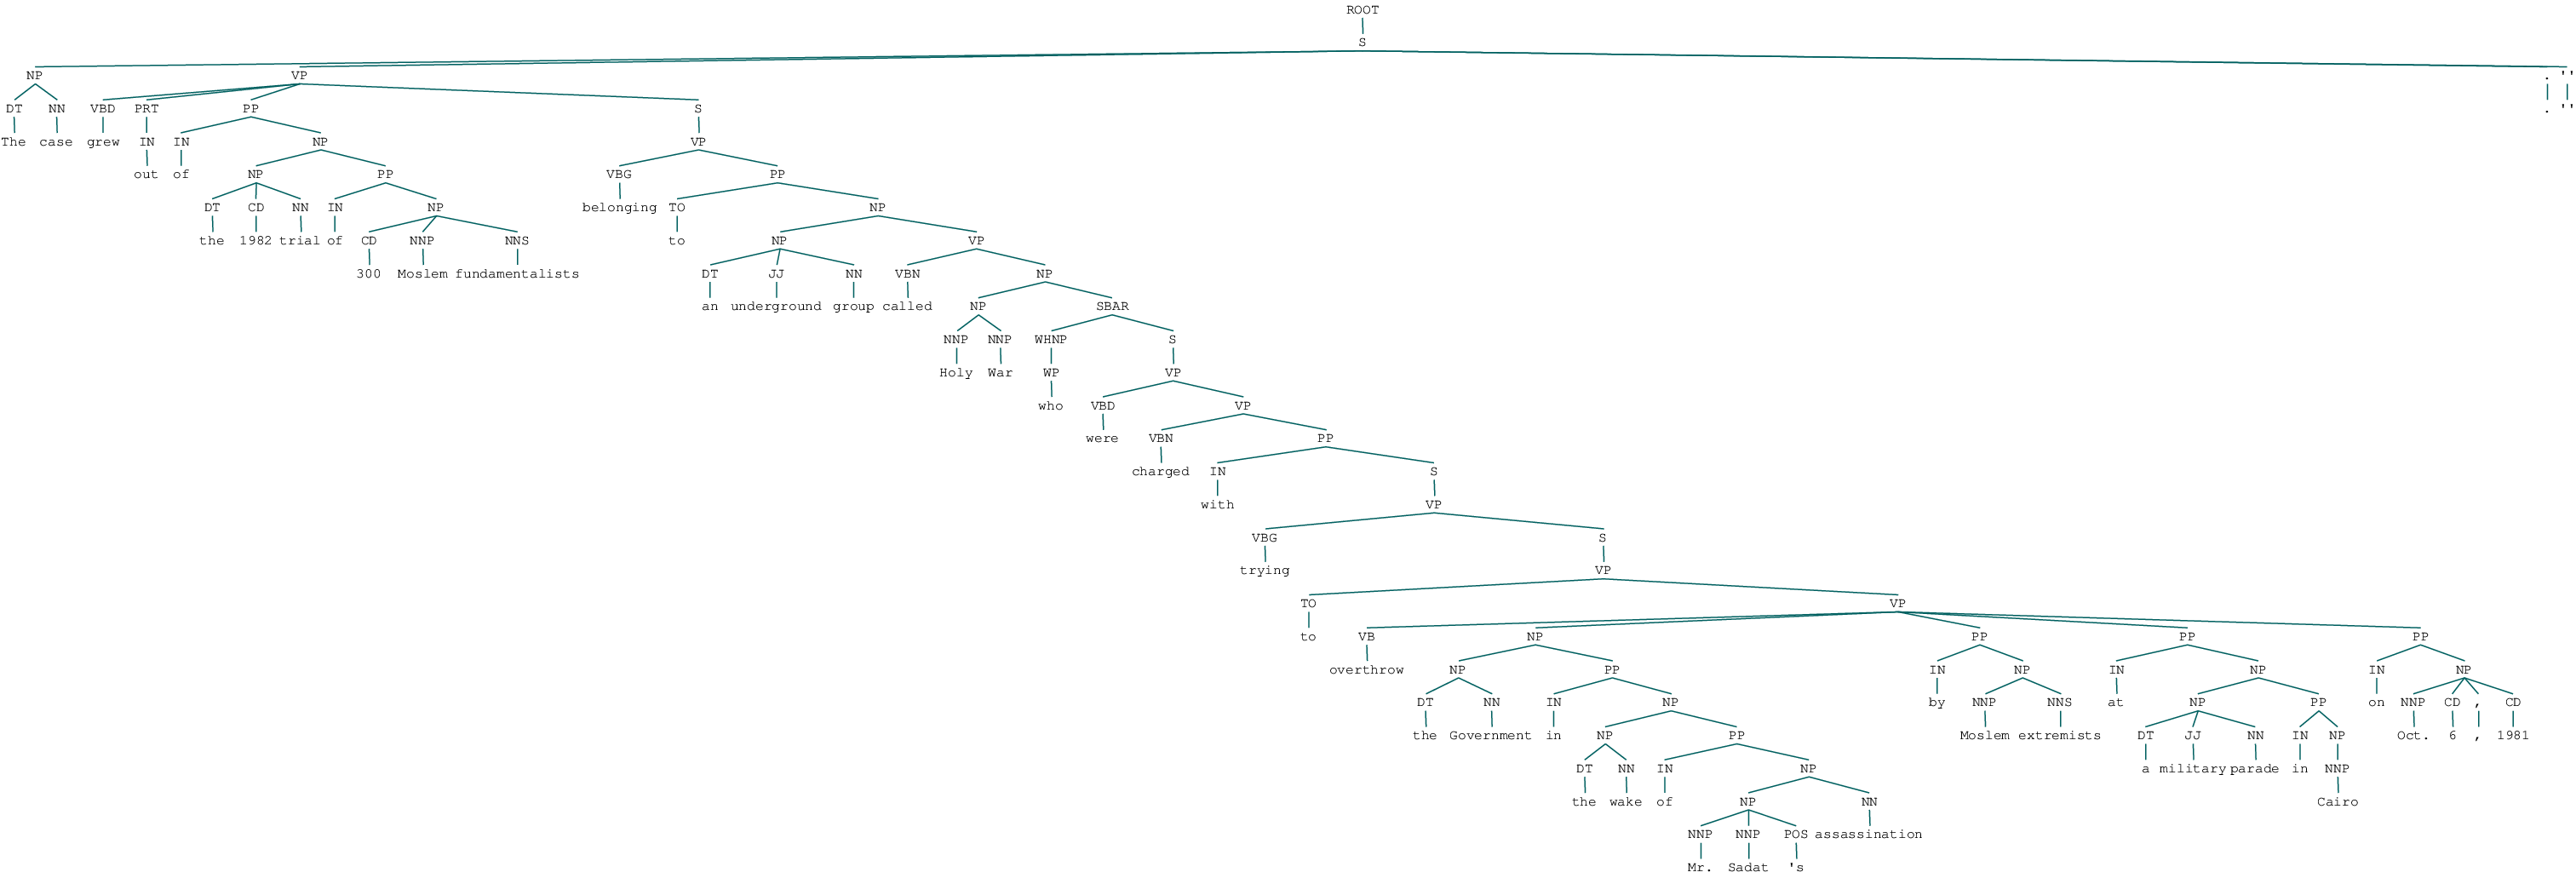

7

'AID = 22952910'

'Code = 186'

'Text = \\nTwo masked gunmen entered a hotel today and opened fire on a group of Basque politicians, killing one legislator and wounding another.\\nThe authorities identified the victims as Jon Muguruza, 31 years old, and Inaki Esnaola, 41.'

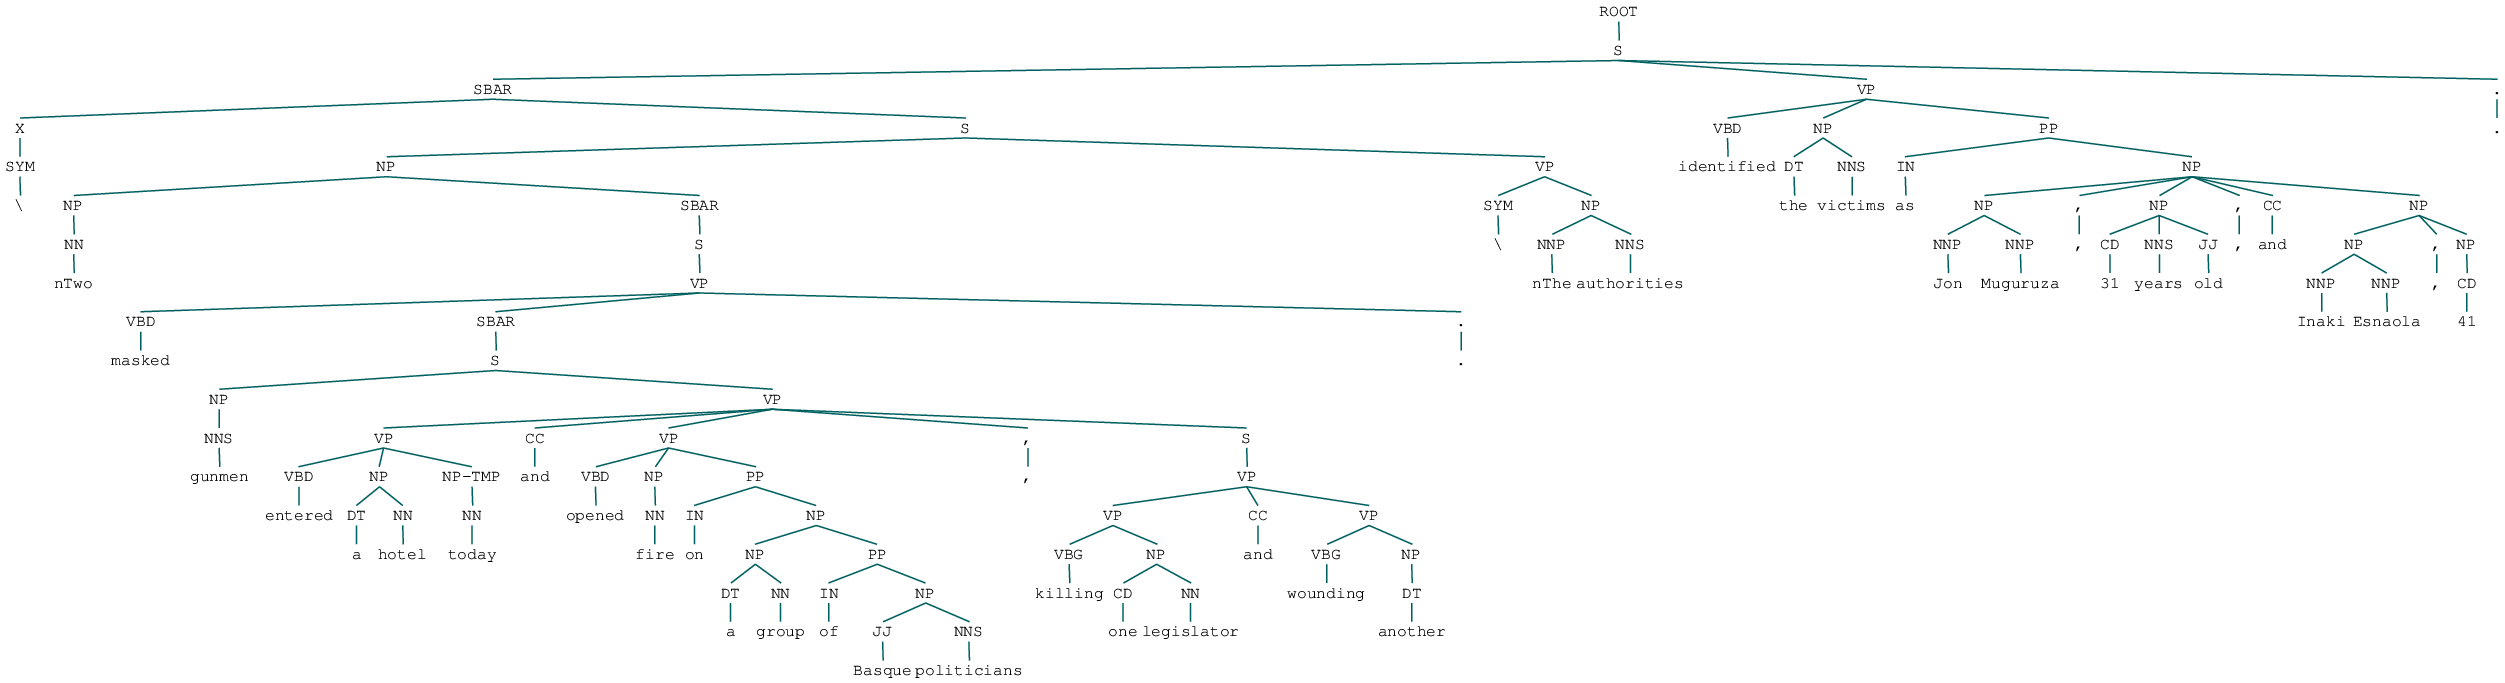

8

'AID = 23000361'

'Code = 186'

'Text = It will be shown at 8 P.M. Friday in the Academic Arts Theater of Westchester Community College in Valhalla.\\n\\n\\nBarbara Hershey has the role of Ruth First, a white anti-apartheid activist who fled South Africa and was assassinated by unknown persons in Mozambique.'

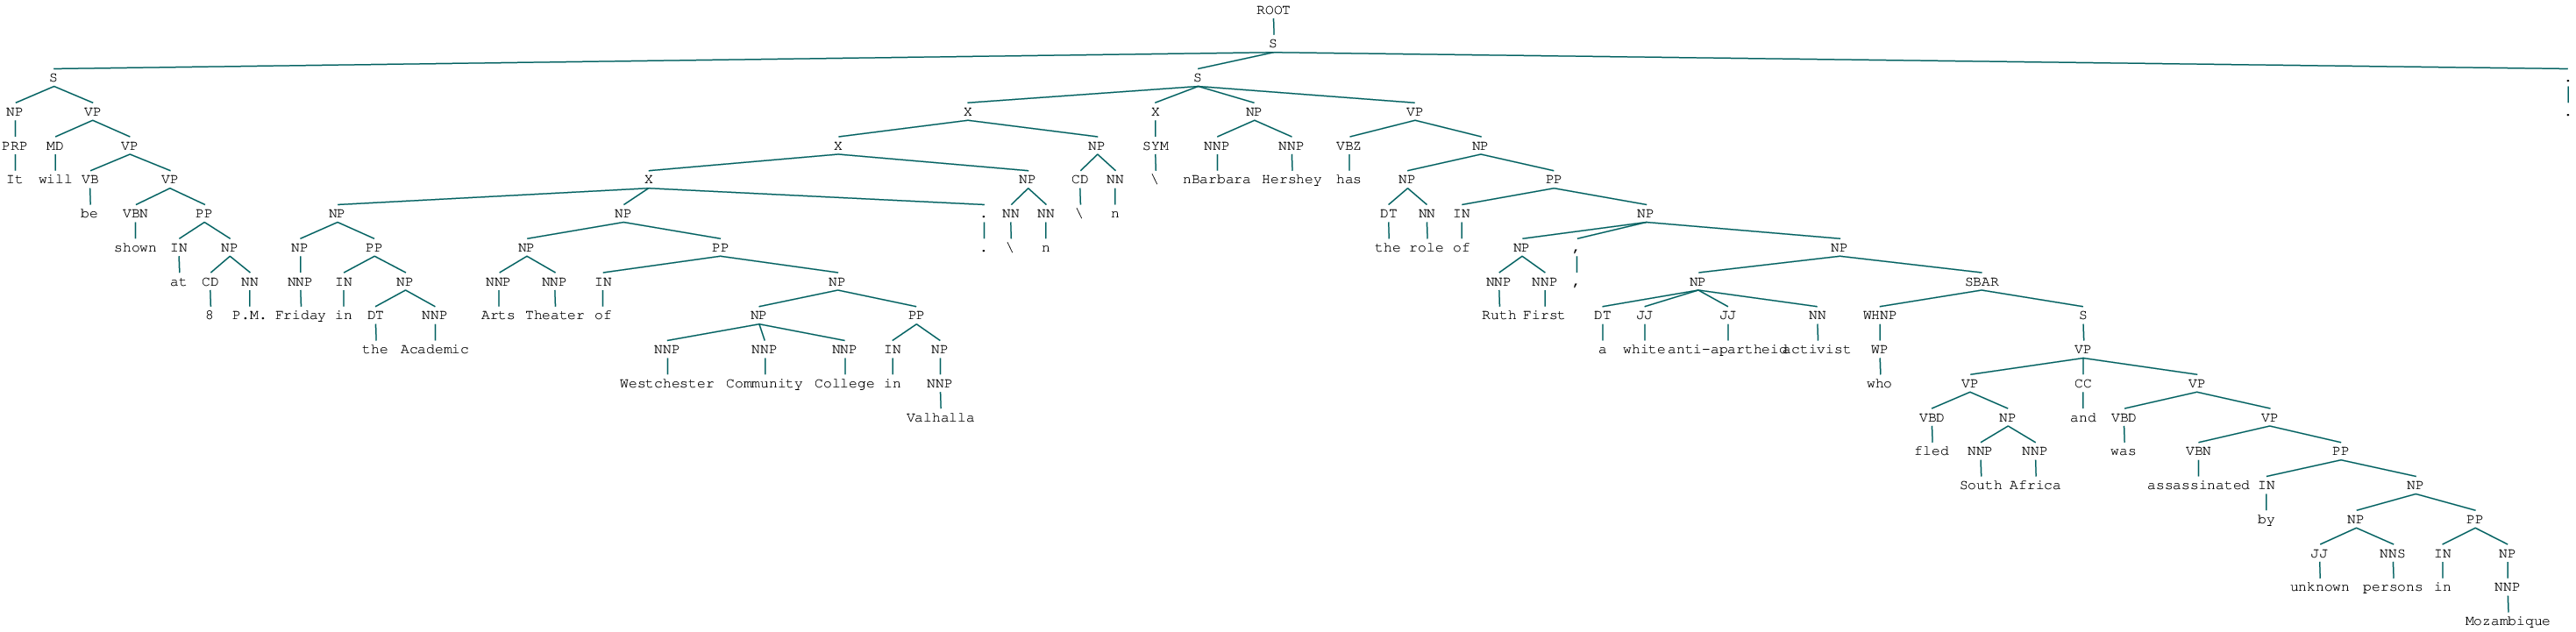

9

'AID = 23164633'

'Code = 186'

'Text = "A gunman in Tunis shot and killed two of the highest-ranking leaders of the Palestine Liberation Organization late Monday night.'

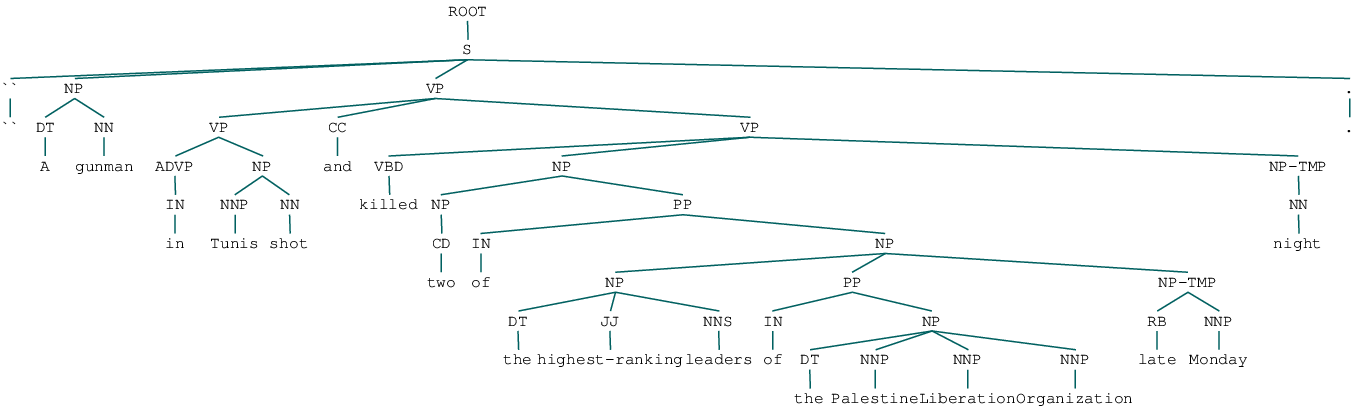

10

'AID = 23394265'

'Code = 186'

'Text = "Special to The New York Times\\nLebanese security authorities say they have arrested four Palestinians in connection with the assassination of a Jordanian diplomat in Beirut last month.\\n\\n The Lebanese authorities identified only one of the four arrested in the killing of Naeb Imran Maaytah, the first secretary of the Jordanian Embassy in Beirut, who was shot to death by a lone gunman as he left his home on Jan. 29.'

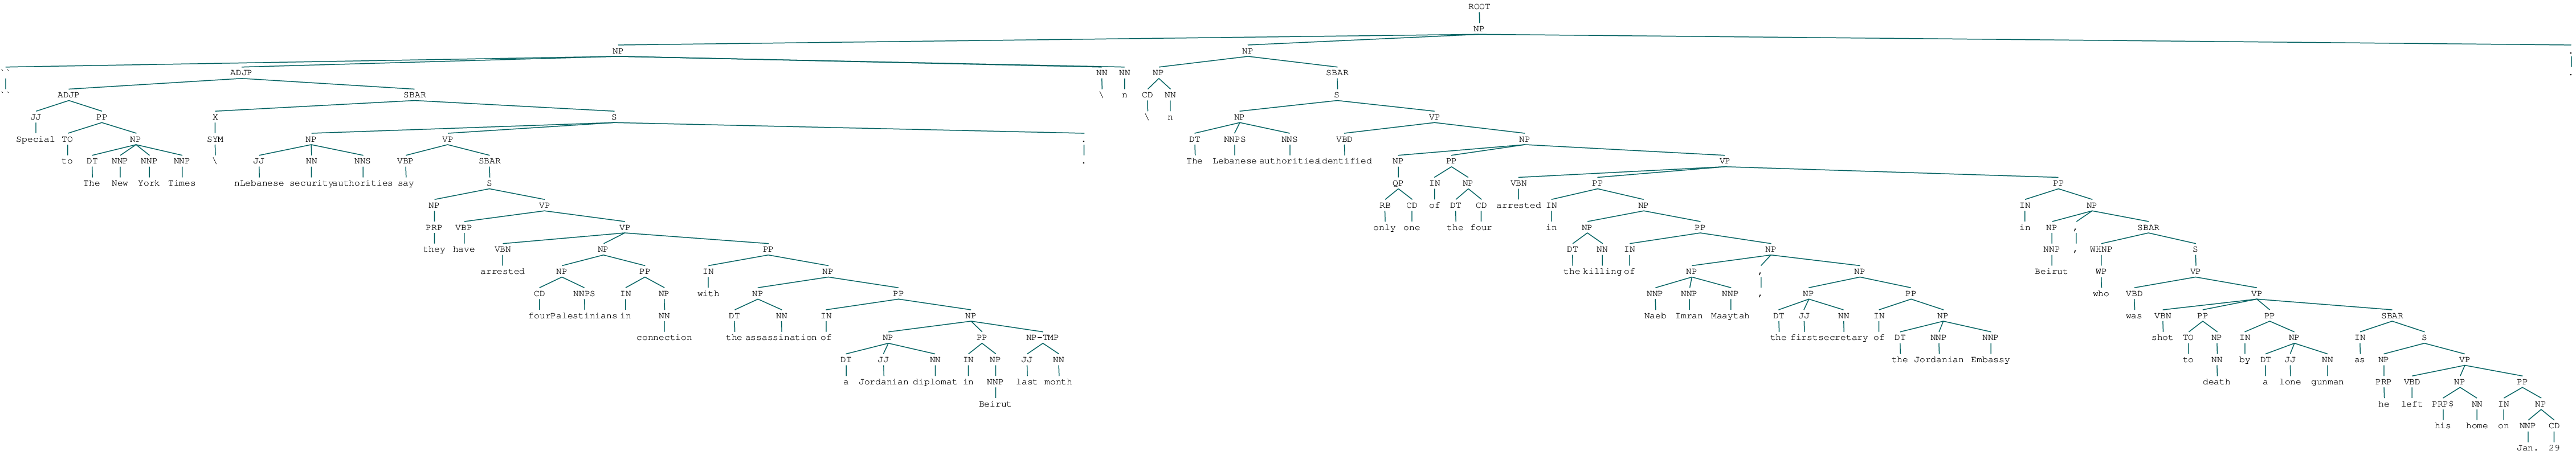

11

'AID = 23547285'

'Code = 186'

"Text = Nearby is Teen Murti Bhavan, Mr. Nehru's official residence during his 17 years as Prime Minister, now a museum, with a bedroom only slightly more indulgent than Gandhi's, as well as a study and reception room preserved as they were in Mr. Nehru's time.\\n\\n\\n\\nAnother short walk away, at 1 Safdarjung Road, is the residence where Nehru's daughter, Indira Gandhi, Prime Minister for 15 years, was assassinated by Sikh security guards as she walked through the garden in October 1984."

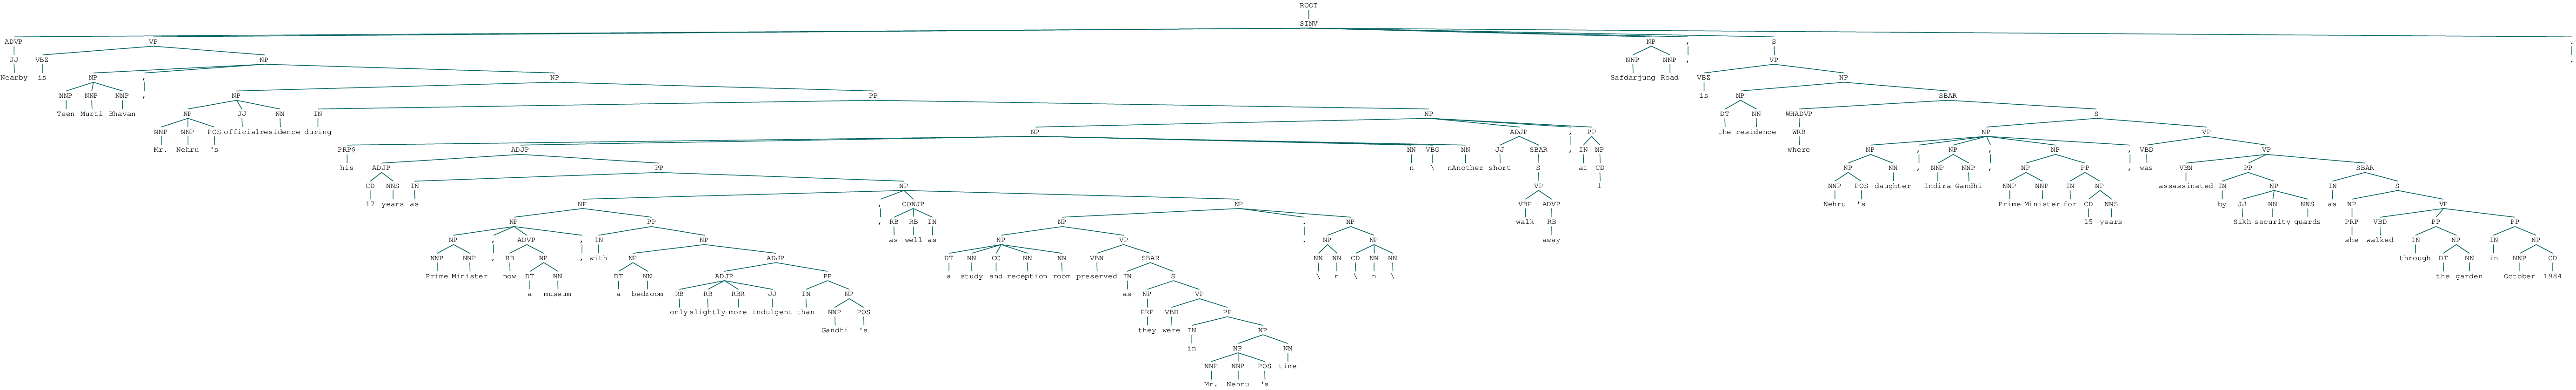

12

'AID = 23587186'

'Code = 186'

'Text = "A parliamentary commission investigating charges that the Turkish Government sponsored death squads and allowed gunmen to smuggle drugs and commit other crimes has recommended that two members of Parliament be stripped of their immunity and brought to trial.\\n\\n\\nThe report said both men may have been leaders of a shadowy gang used by the Government in recent years to assassinate perceived enemies of the state.\\n\\n  One of them, Sedat Bucak, is chief of a pro government Kurdish militia that has been helping the army fight Kurdish rebels.'

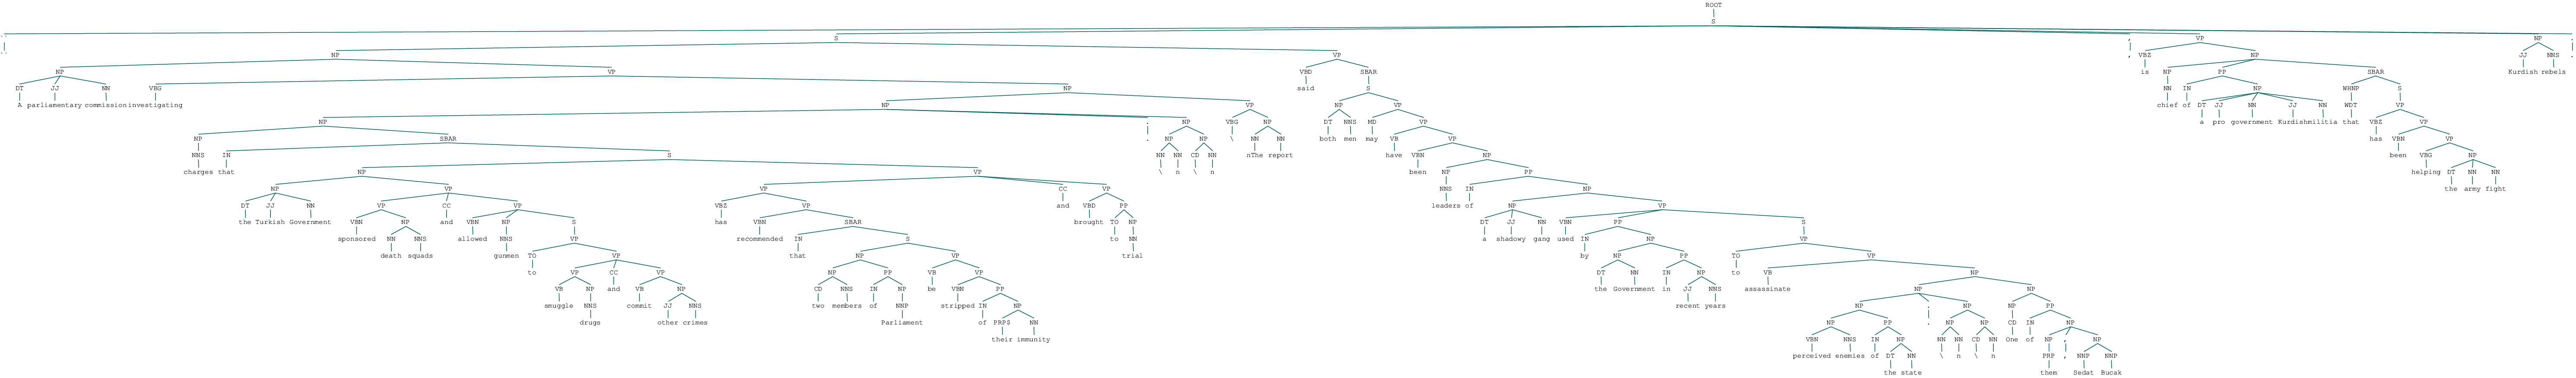

13

'AID = 23588926'

'Code = 186'

"Text = Major Buyoya is a Tutsi; his predecessor was a Hutu.\\n\\nMore than 150,000 people have died in violence since Tutsi paratroopers assassinated the country's first democratically elected president, a Hutu, in a failed coup in 1993."

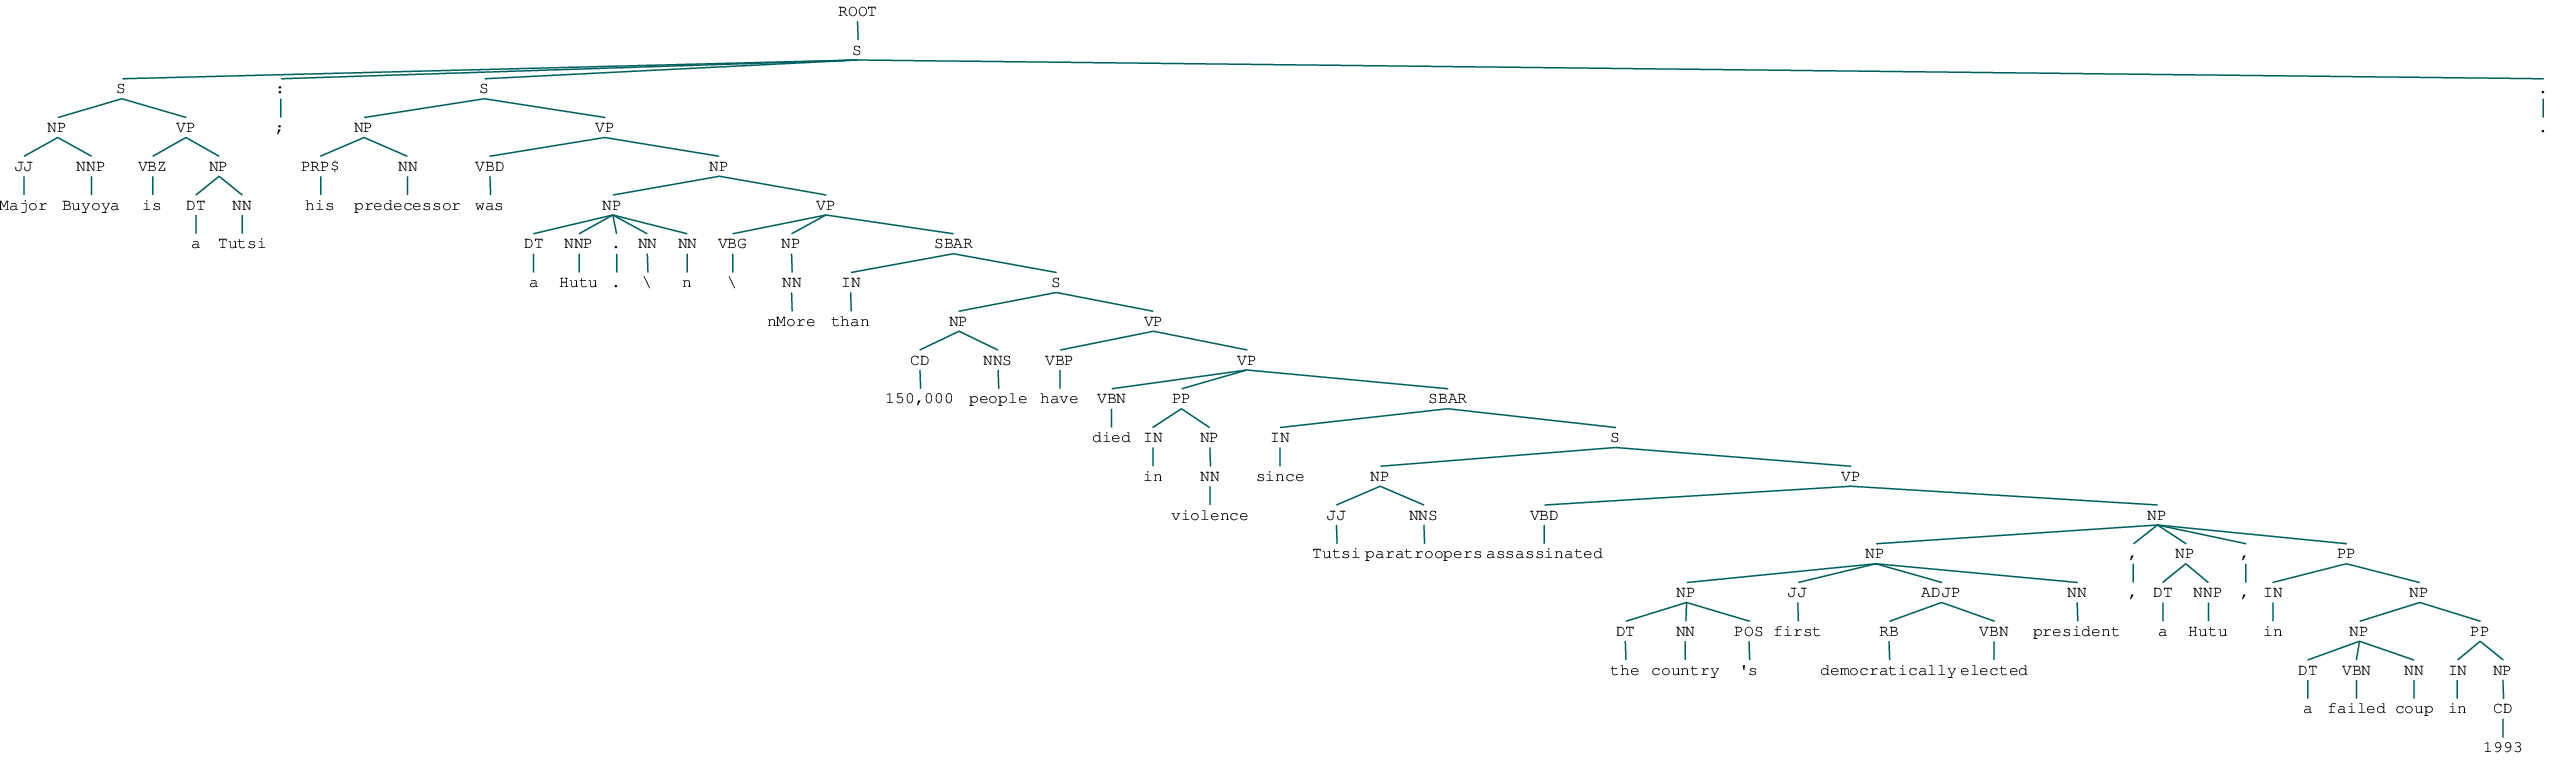

14

'AID = 23706097'

'Code = 186'

'Text = A commentary in the government-run newspaper Al Jumuriya called the killings \'\'part of the conspiracies against Iraq.\'\'\\n\\n\\nIraq also said that it had caught some members of a gang that assassinated Ayatollah Sadr, but it did not provide any details about the suspects."'

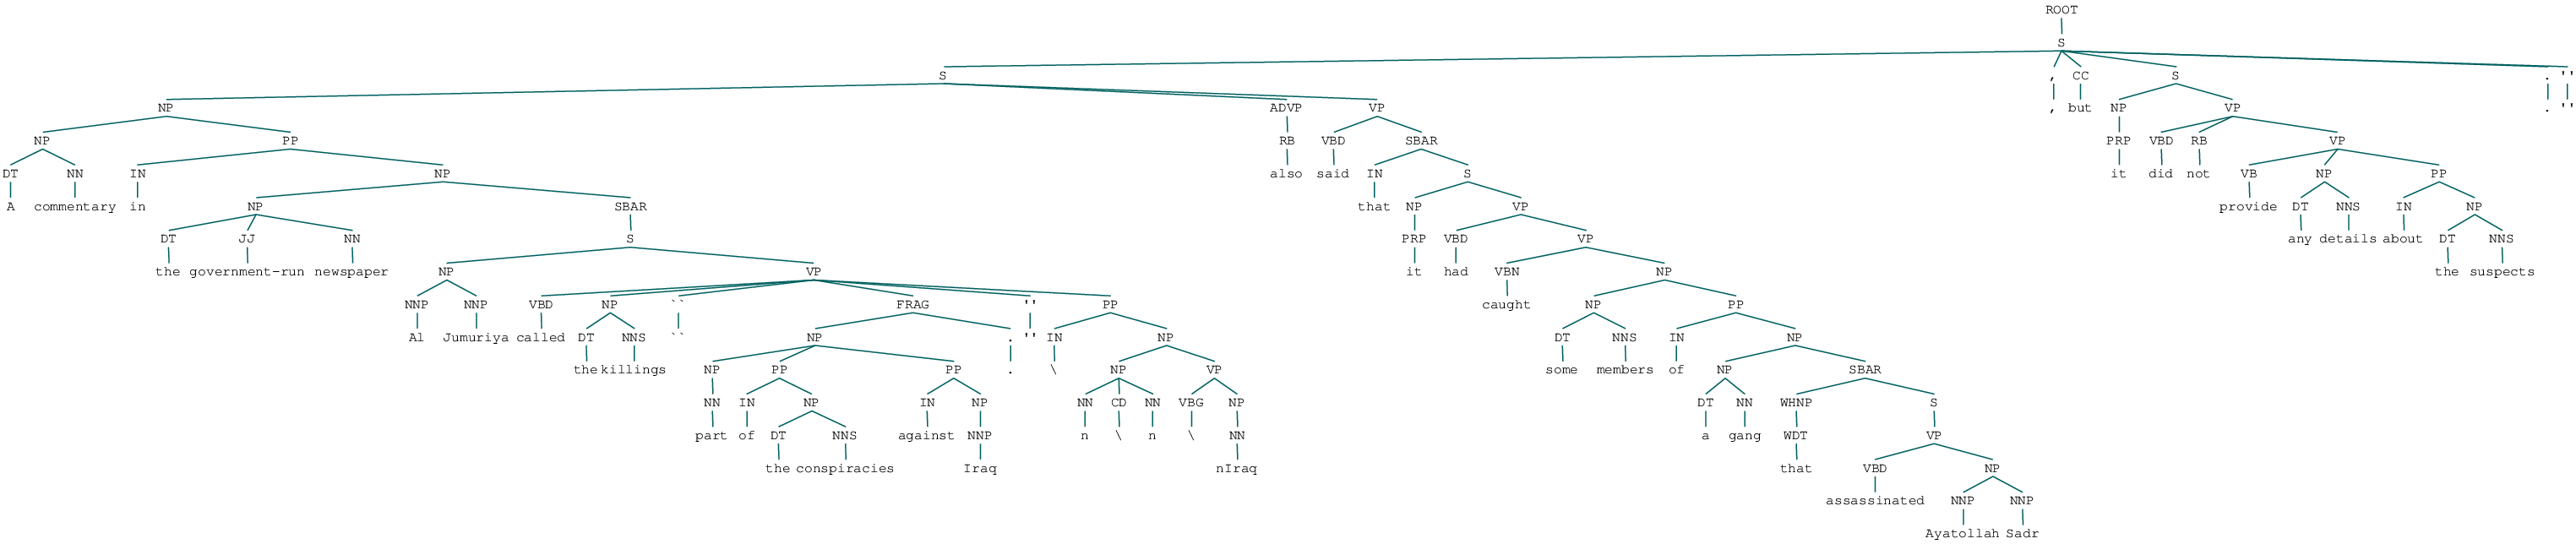

15

'AID = 23740220'

'Code = 186'

'Text = A gunman killed the former high-ranking leader of the Kosovo Liberation Army outside his home.'

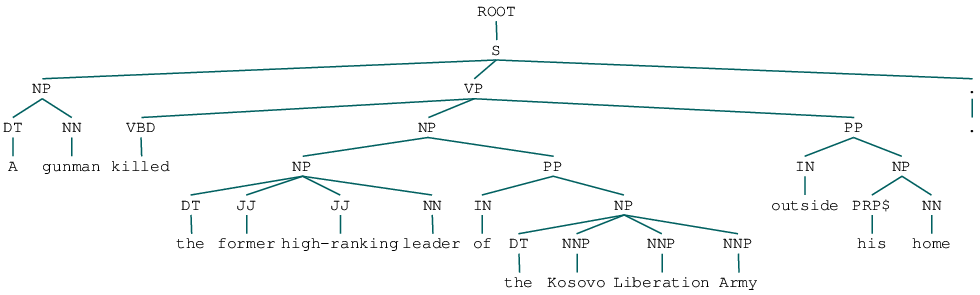

16

'AID = 23787546'

'Code = 186'

'Text = Since then, three other American officials and an embassy employee have been killed by the group and dozens of Americans have been wounded.\\n\\n\\nIn June 2000, November 17 assassinated Stephen Saunders, a British military attache, as he sat in his car on a busy Athens street.'

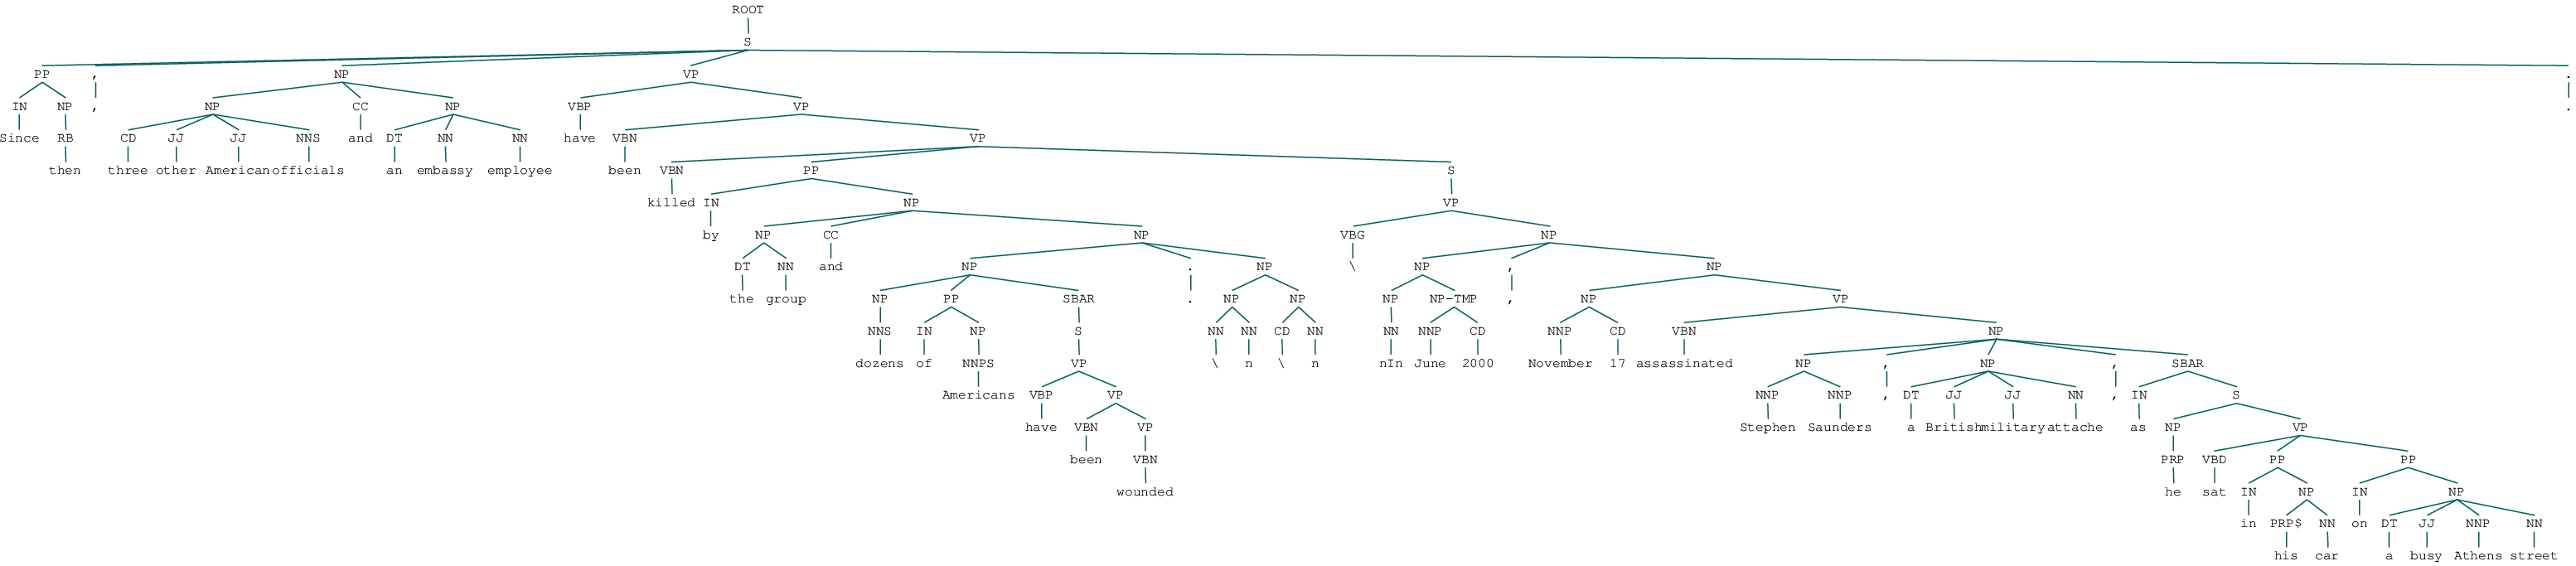

17

'AID = 23816464'

'Code = 186'

'Text = "An Egyptian who was said to have given a letter of accreditation to two men who posed as television journalists to assassinate the Afghan rebel leader Ahmed Shah Massoud was charged today with conspiracy under Britain\'s anti terrorism law.\\n\\nMr.'

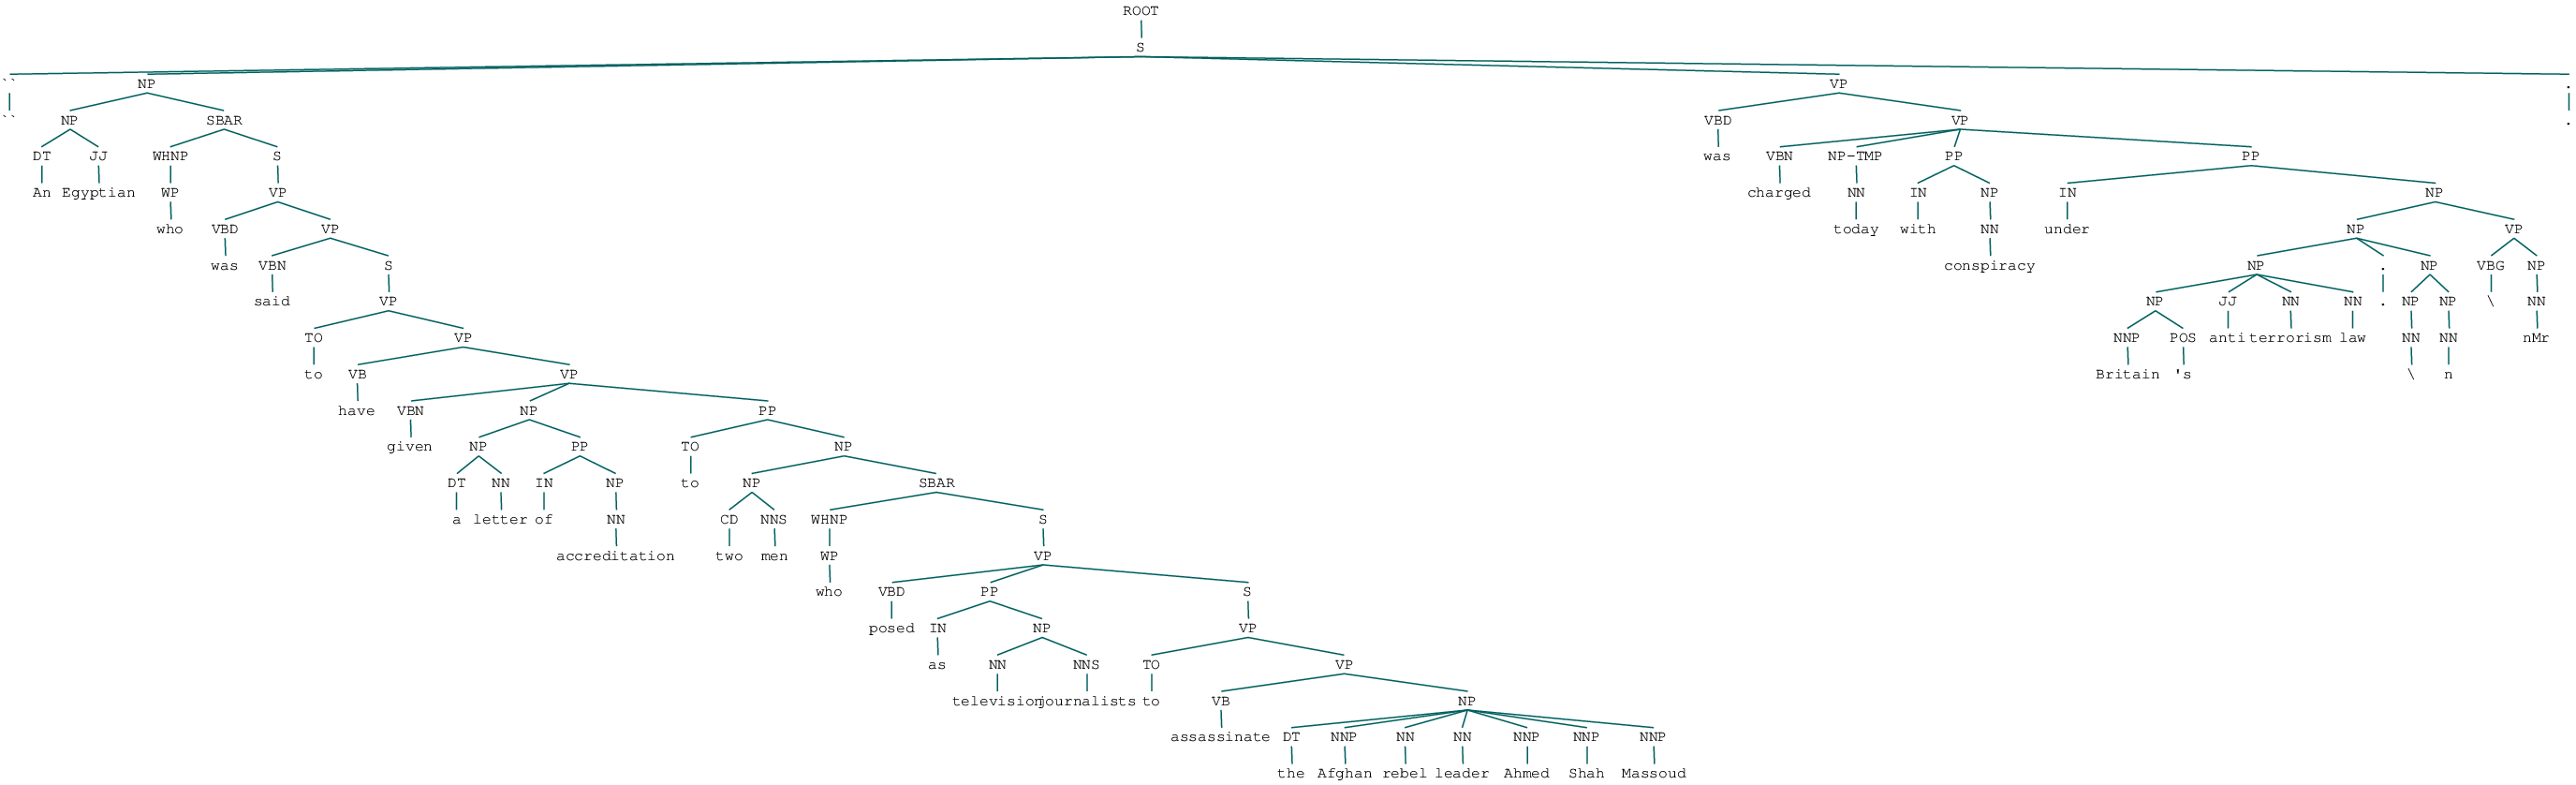

18

'AID = 23817197'

'Code = 186'

"Text =  it will be harder to oust the Taliban and to achieve the American aim of installing a stable government representing a broad array of Afghanistan's factions and ethnic groups.\\nIn the last two months, the Taliban and Al Qaeda, Osama bin Laden's terrorist network, have succeeded in killing both Mr. Haq and Ahmad Shah Massoud, the charismatic military leader of the Northern Alliance."

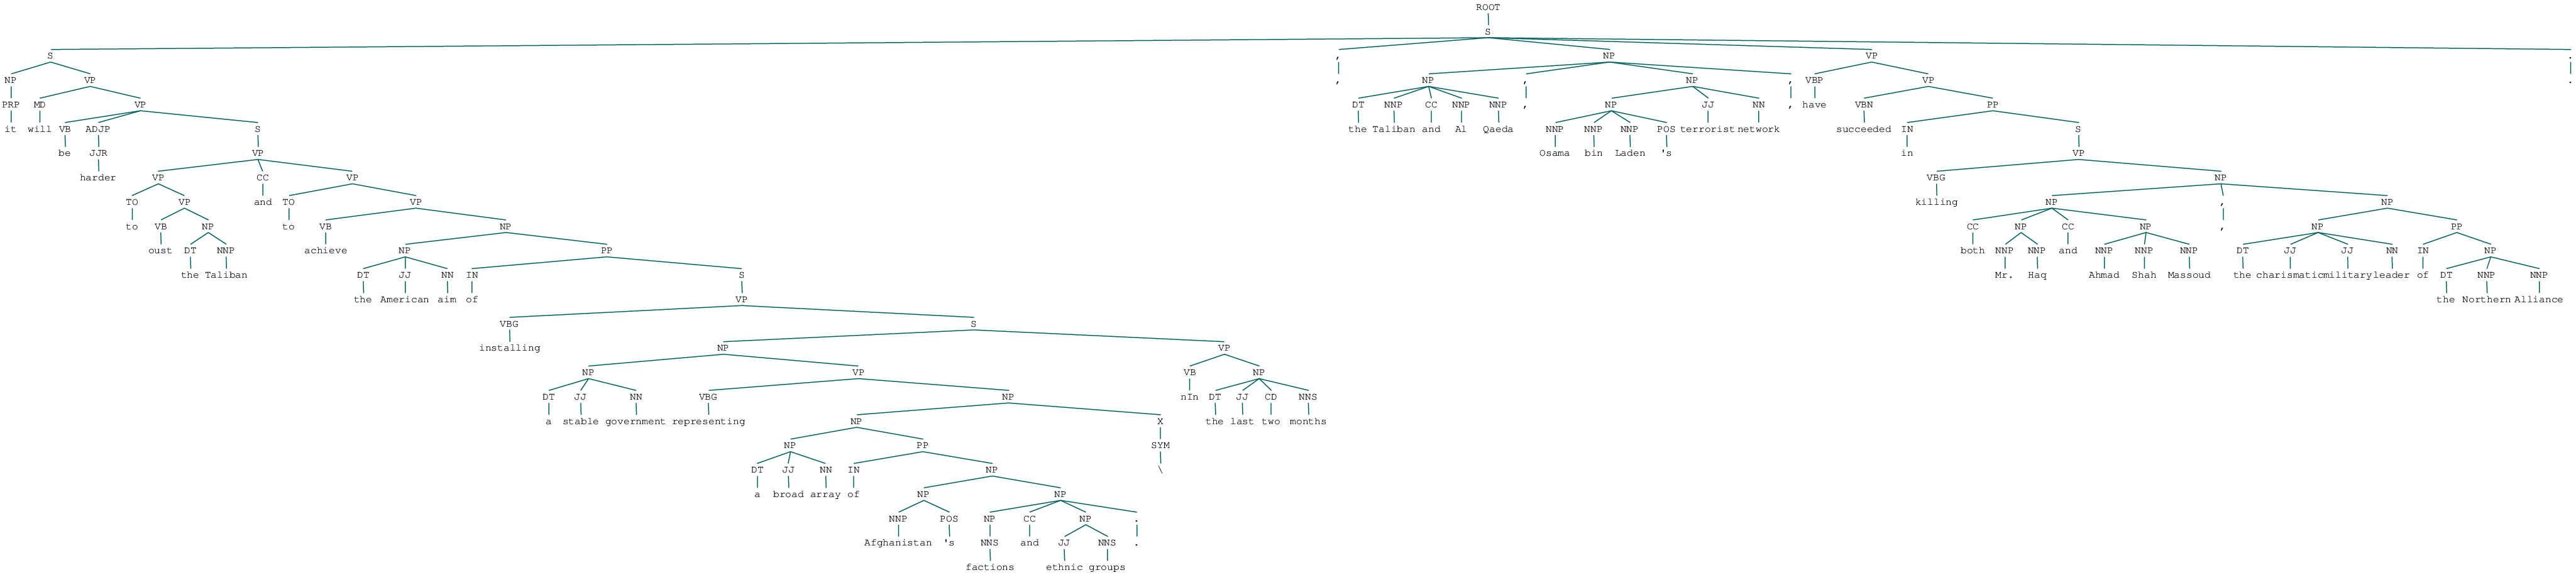

19

'AID = 23853527'

'Code = 186'

"Text = shows the Israeli prime minister was probably not happy with these initiatives and efforts and said, 'I will go ahead with this strike to sabotage these efforts,' '' Mr. Mubarak told reporters in Paris.\\n\\nPalestinian officials and European diplomats say that a Palestinian ceasefire was in the works when Israel sent an American-made F-16 fighter over Gaza City to kill the militant leader."

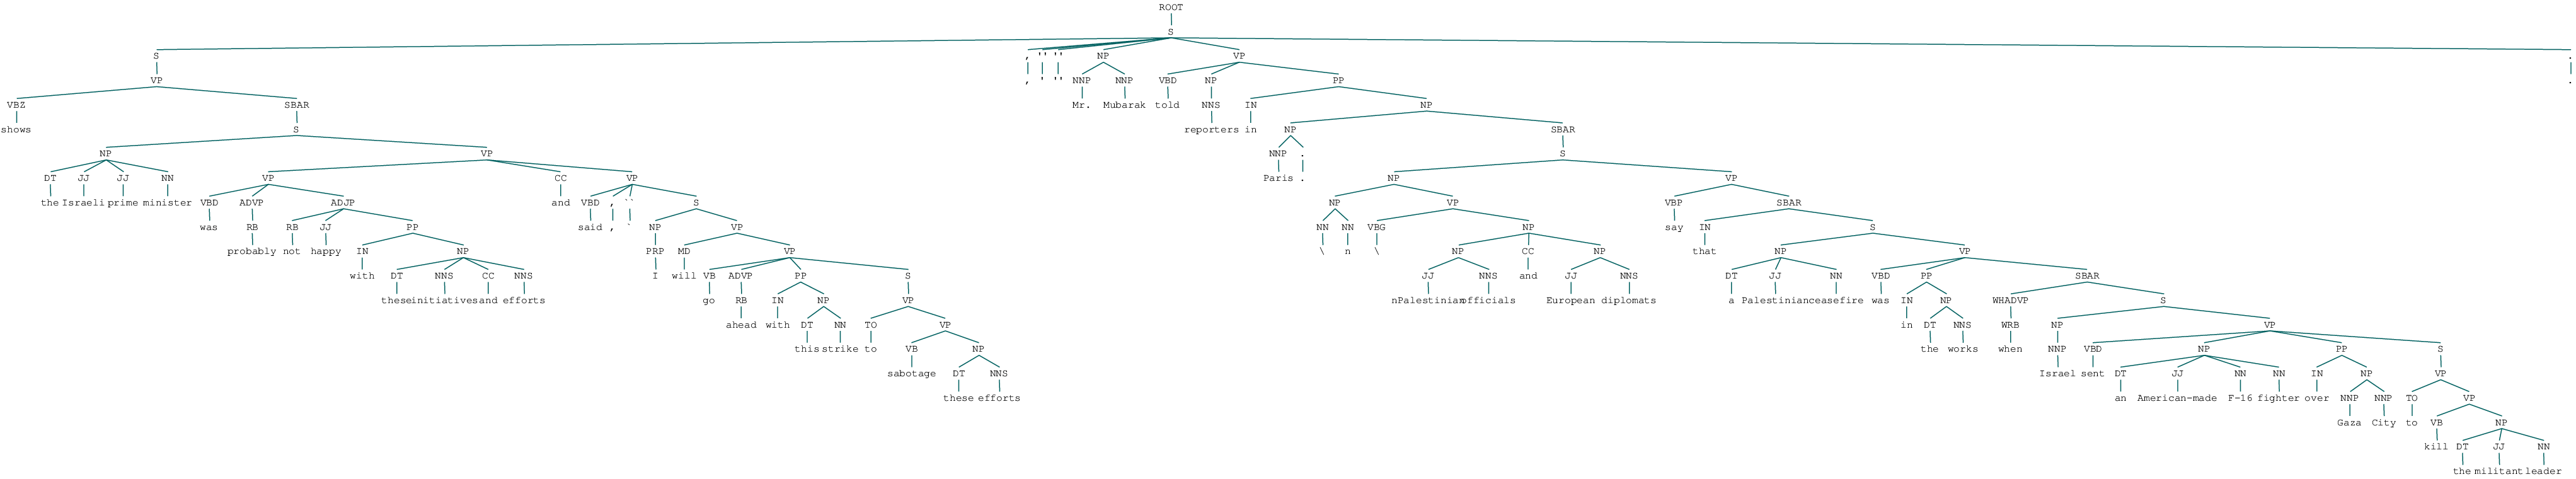

20

'AID = 23965701'

'Code = 186'

"Text = \\n\\nA Father's Presence\\n\\nWhatever Mr. Bush's reasons for the war, it is hard not to consider whether it was in part a personal vendetta for a man who has often publicly recalled a plot directed by Mr. Hussein to assassinate his father in 1993."

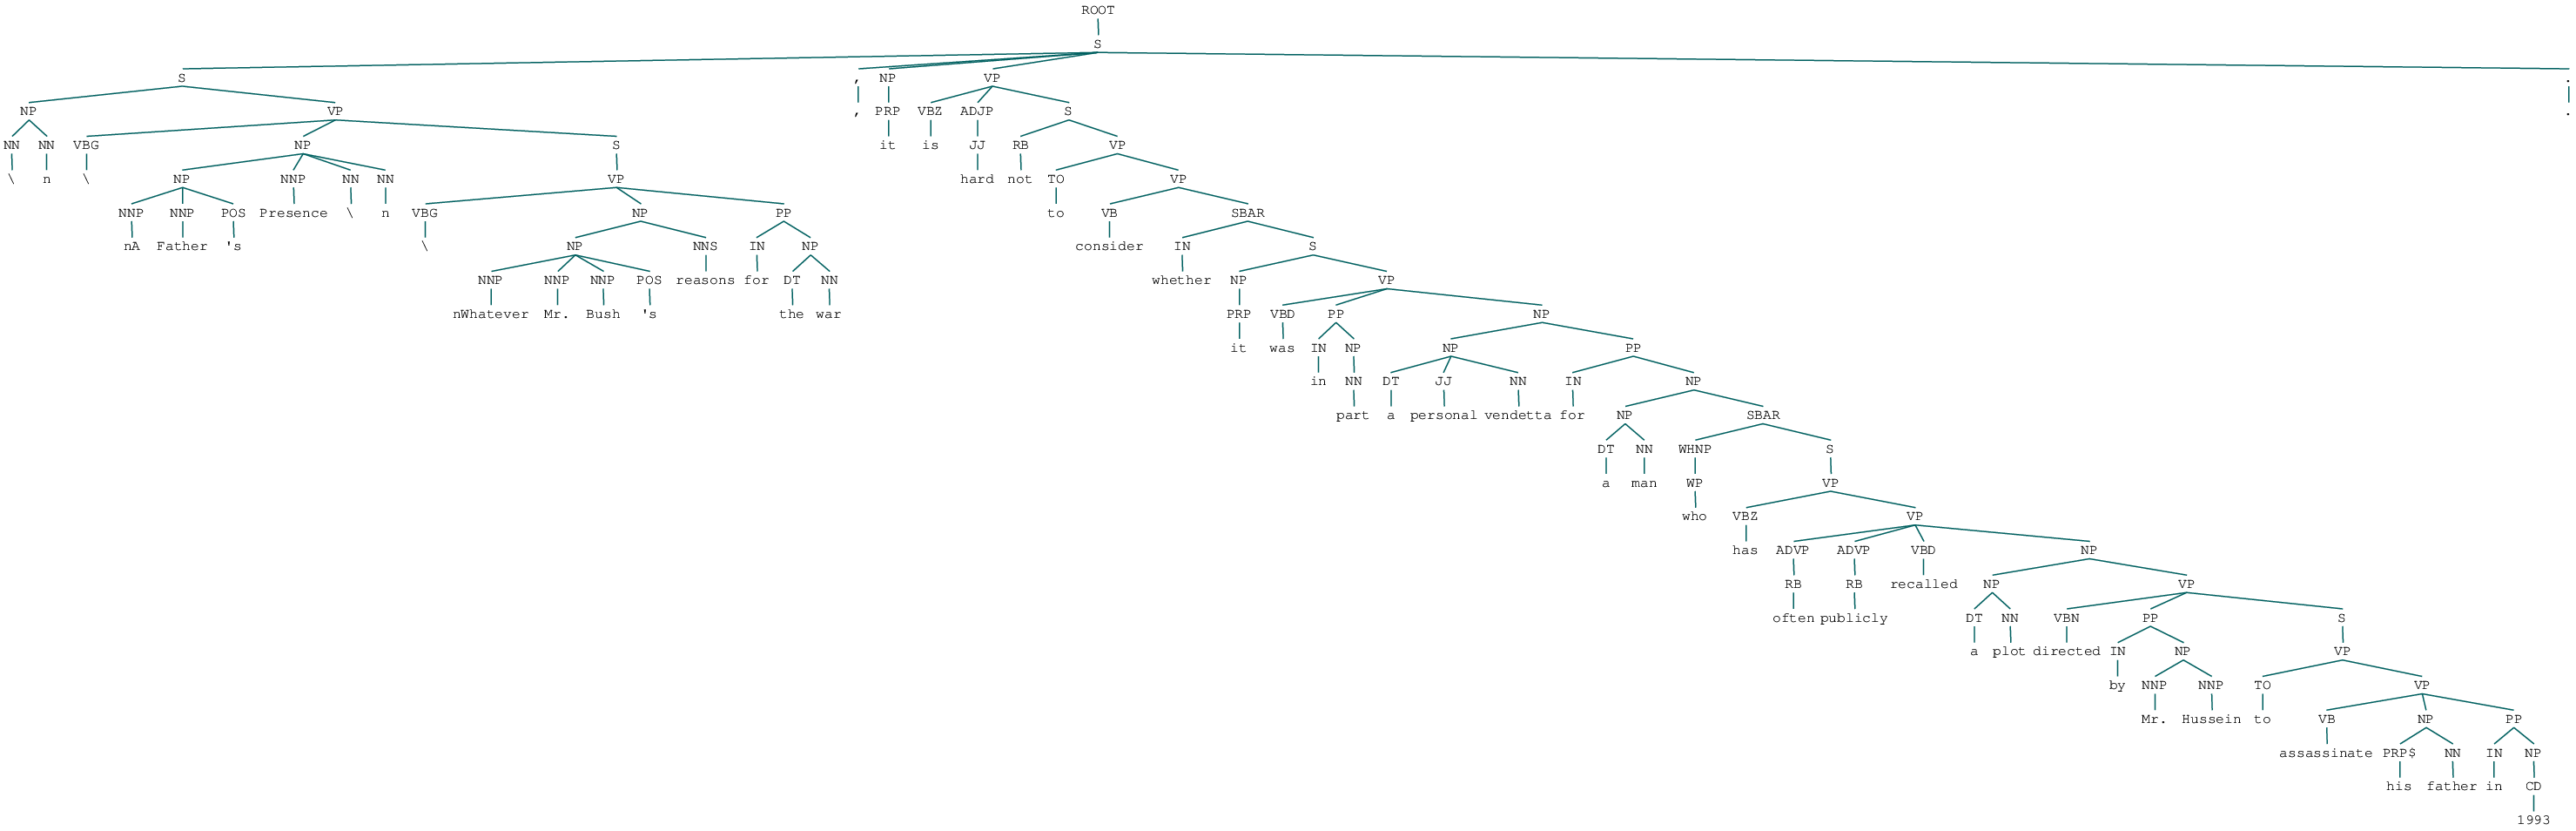

21

'AID = 24016041'

'Code = 186'

'Text = Mr. Kostunica withdrew his Serbian Democratic Party from the coalition, accusing the prime minister, Zoran Djindjic, of abusing the law in his pursuit of reforms and failing to crackdown on criminals, some of whom the president claimed were closely linked to Mr. Djindjic.\\n\\n\\n\\nTwo senior aides to Mr. Djindjic, who was assassinated last March by a member of an elite police squad that prosecutors say has links to organized crime,'

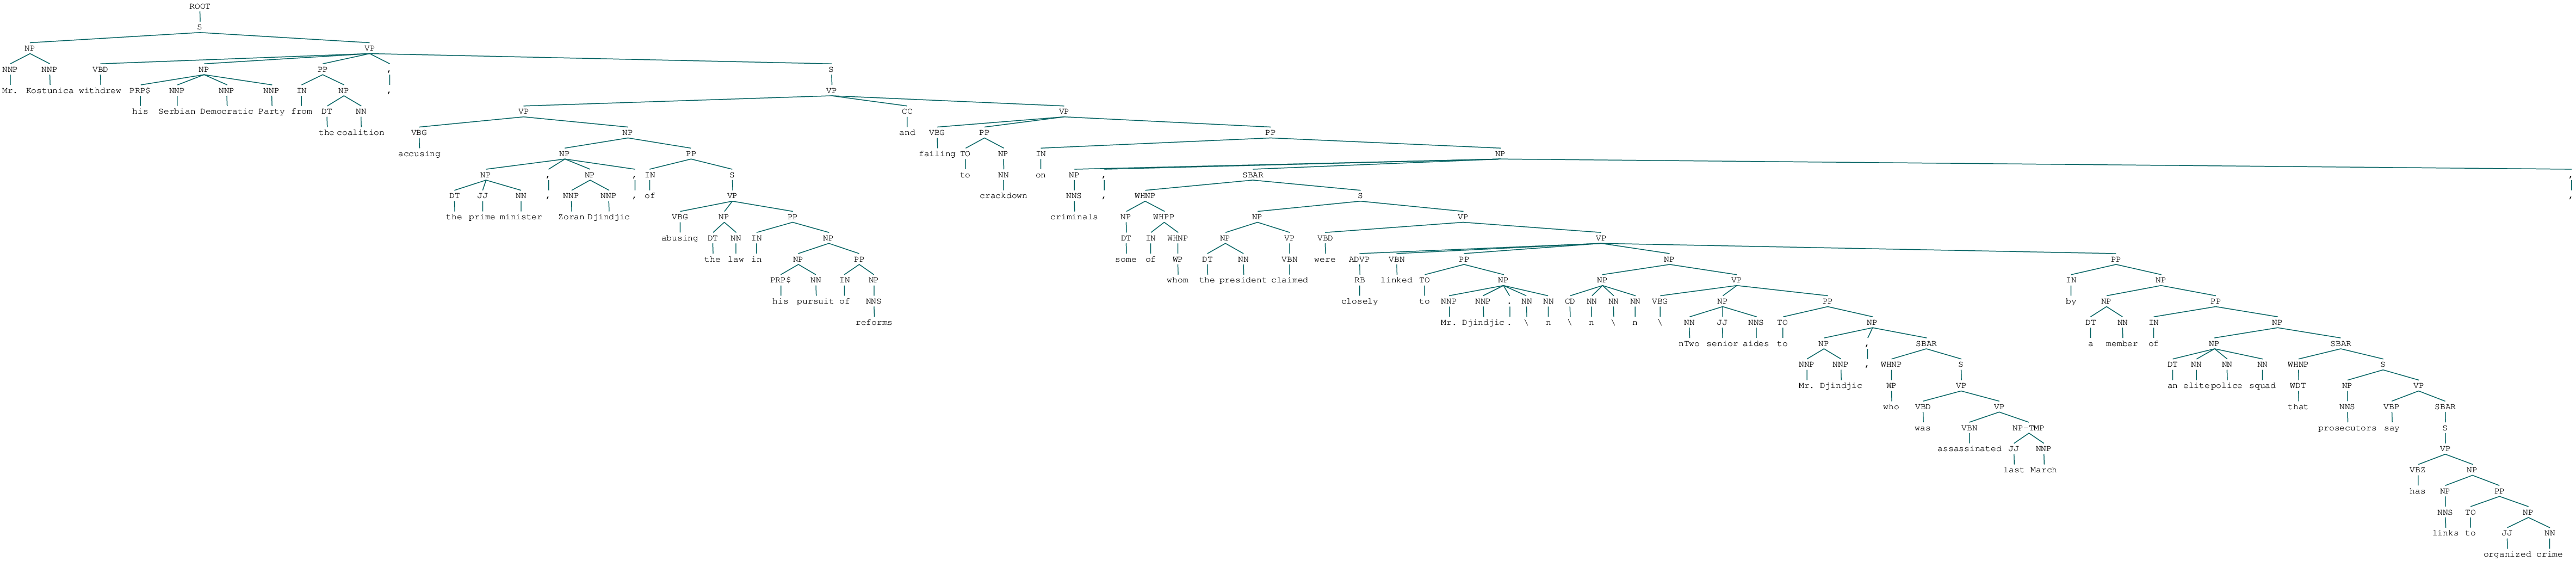

22

'AID = 24063647'

'Code = 186'

'Text = Mr. Moiseyev, the prosecutor, said it was the first time a case had been filed in Nizhny Novgorod under that article in the criminal code.\\n\\n\\nBoth charges involved open letters published in 2004 by Aslan Maskhadov, the Chechen leader killed by Russian forces in March, and by Akhmed Zakayev, the separatist spokesman who received political asylum in Britain.\\n\\nThe letters passionately criticized Kremlin policies, but did not single out any ethnic group.'

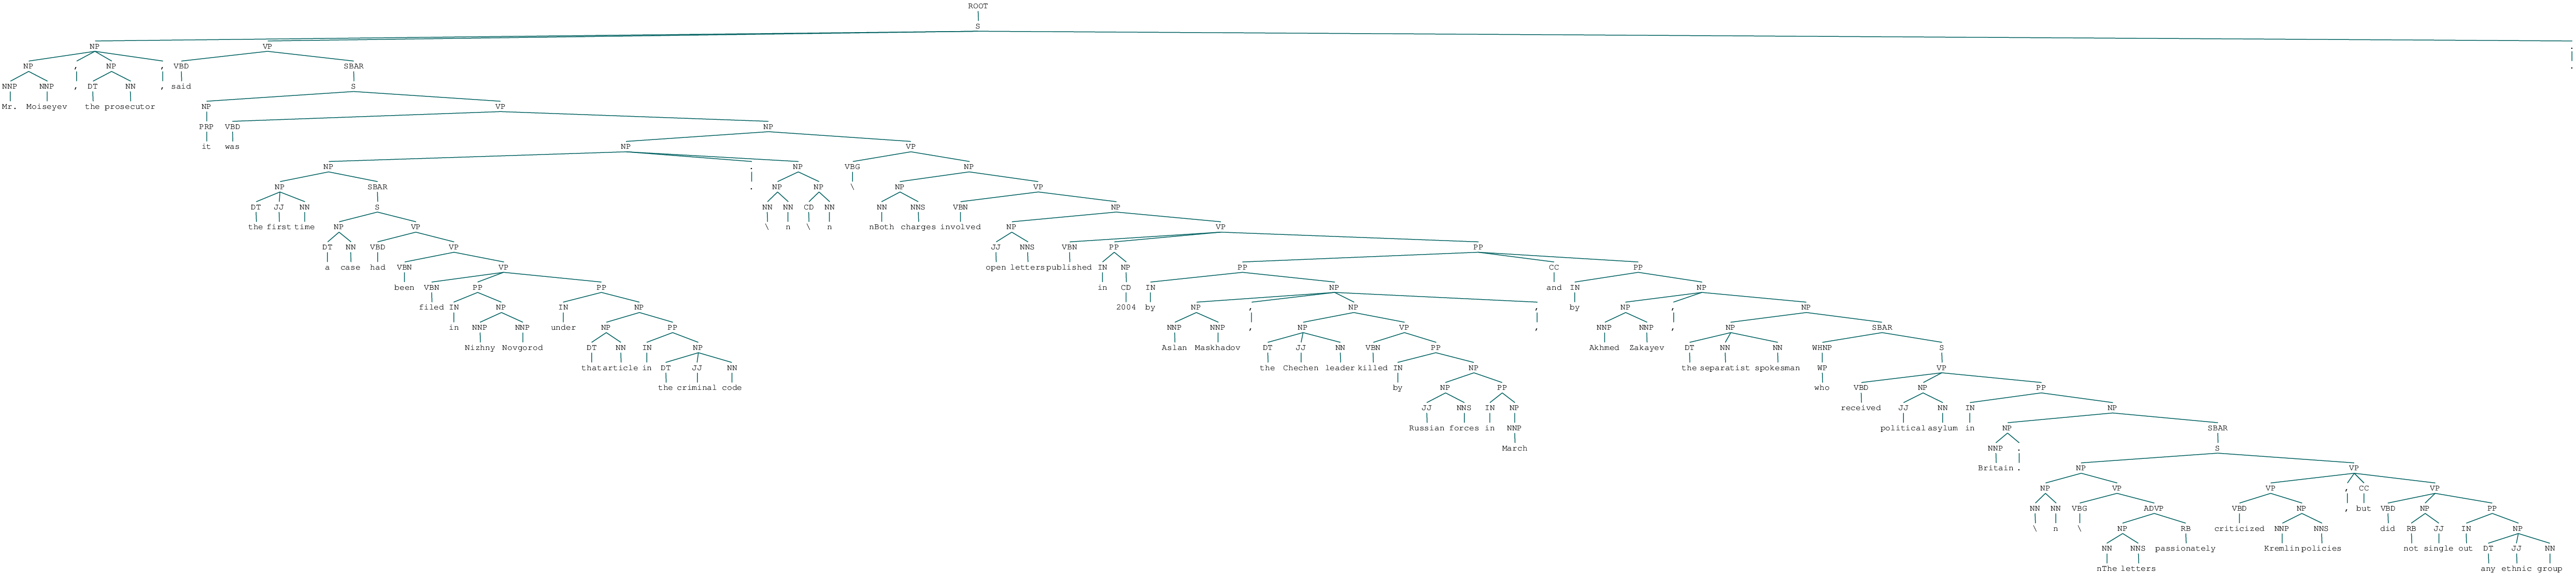

23

In [58]:
for i in range(len(accent4_186)):
    parsed_output(accent4_186, i)
    display(i)

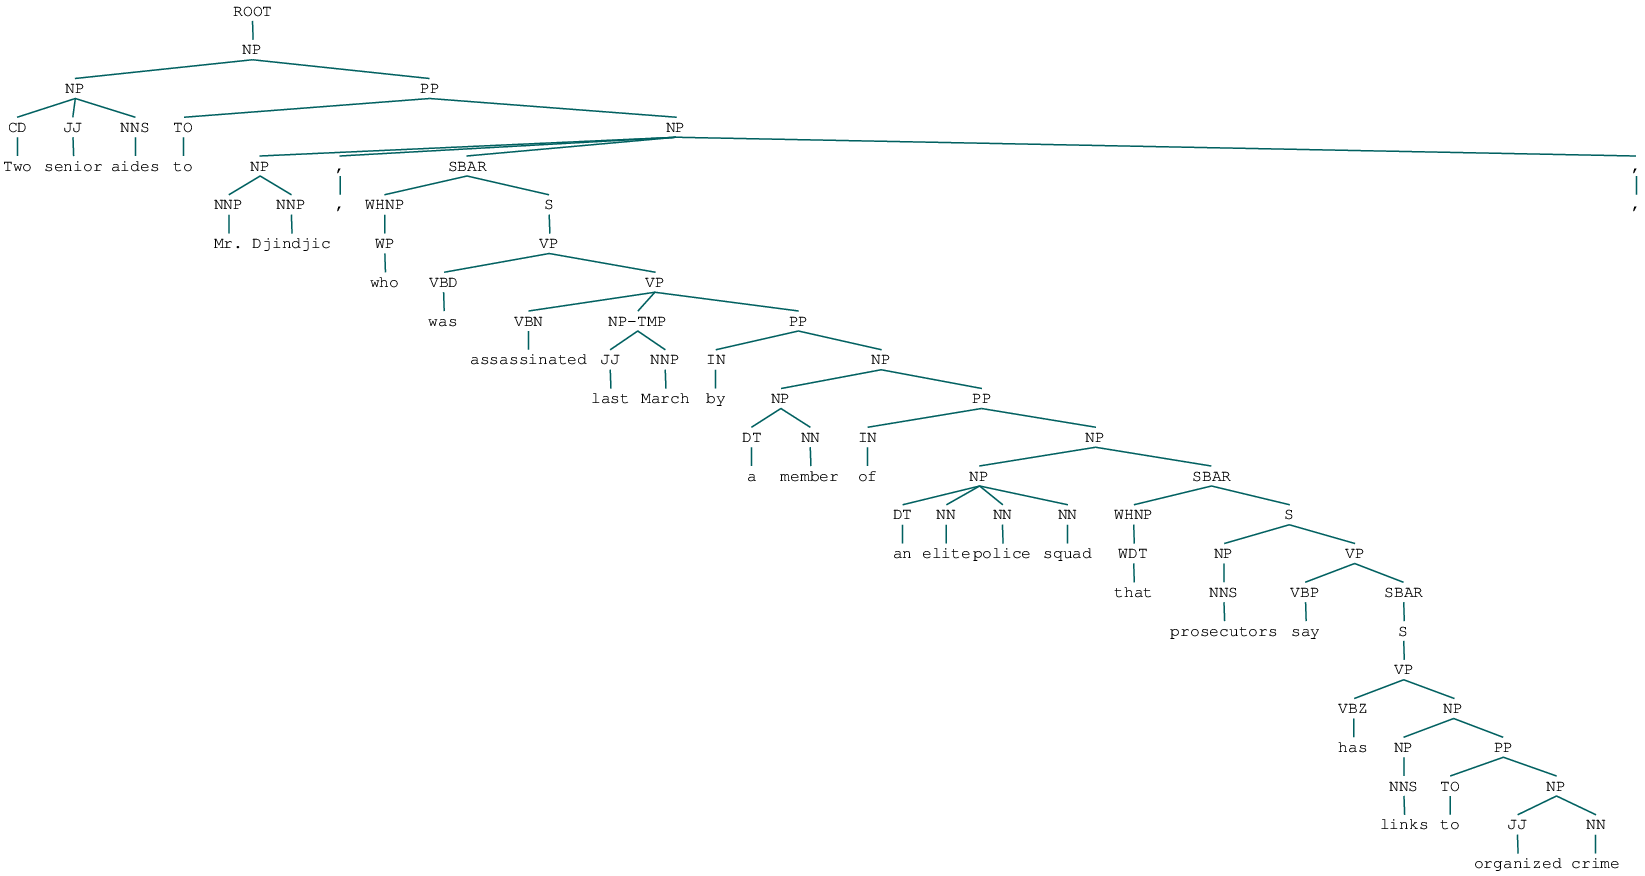

In [74]:
one_sentence_parser("Two senior aides to Mr. Djindjic, who was assassinated last March by a member of an elite police squad that prosecutors say has links to organized crime,")